## Problem statement
* [Introduction](#Introduction)
* [1. EDA & Data Transformation](#1.-EDA-&-Data-Transformation)
  * [1.1 Checking Missing](#1.1.-Checking-missing-values)
* [2. Feature Engineering](#2.-Feature-Engineering)
  * [2.1 Handling Missing Data](#2.1-Handling-Missing-Data)
  * [2.2 Dealing with Locational Data](#2.2-Dealing-with-Locational-Data)
    * [2.2.1 Kmeans for an Try to Rescue](#2.2.1-Kmeans-for-an-Try-to-Rescue)
  * [2.3 Date_Time conversion](#2.3-Date-Time-conversion)
  * [2.4 Dropping unwanted ](#2.4-Dropping-unwanted )
  * [2.5 Encoding](#2.5-Encoding)
  * [2.6 Text Preprocessing](#2.6-Text-Preprocessing)
  * [2.7 Tfidf Text features](#2.7-Tfidf-Text-features)
  * [2.8 Data Split](#2.8-Data-Split)
* [3 Text Features and categorical Features in Catboost](#3-Text-Features-and-categorical-Features-in-Catboost)

<!-- ## 2.4 Dropping unwanted  -->

# Introduction

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix,coo_matrix
import scipy

In [3]:
import nltk
import string
import spacy
en_core = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.tokenize.regexp import regexp_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
le=LabelEncoder()



In [5]:
train_df=pd.read_csv('./dataset/train_file.csv')
test_df=pd.read_csv('./dataset/test_file.csv')

In [6]:
train_df

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location,Category
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16T00:00:00,2018-01-16T00:00:00,NaN,2019-07-16T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.636732,-122.319828,"{'latitude': '47.63673222', 'human_address': '...",SINGLE FAMILY / DUPLEX
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13T00:00:00,2015-04-16T00:00:00,2016-11-15T00:00:00,2016-10-16T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.518298,-122.355555,"{'latitude': '47.51829831', 'human_address': '...",COMMERCIAL
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04T00:00:00,2014-09-04T00:00:00,2015-11-20T00:00:00,2016-03-04T00:00:00,Permit Closed,IA/INTERIOR ARCHITECTS,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.624025,-122.337567,"{'latitude': '47.62402492', 'human_address': '...",COMMERCIAL
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.595020,-122.328530,"{'latitude': '47.59502036', 'human_address': '...",COMMERCIAL
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02T00:00:00,2013-12-19T00:00:00,2015-05-14T00:00:00,2015-06-19T00:00:00,Permit Closed,SEATTLE PARKS DEPT,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.705686,-122.320134,"{'latitude': '47.70568601', 'human_address': '...",COMMERCIAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33534,6093924,Construction,3516 S JUNEAU ST,Interior repairs and modifications to existing...,NaN,Plan Review,"SINGER, BILL",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.550138,-122.288036,"{'latitude': '47.55013793', 'human_address': '...",SINGLE FAMILY / DUPLEX
33535,6420980,Construction,1106 M L KING JR WAY S,Construct south duplex (units C&D) with one su...,ADD/ALT,Plan Review,"ZHANG, MOON",2014-06-04T00:00:00,2014-09-10T00:00:00,2015-09-01T00:00:00,2016-03-10T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,3017193.0,47.592970,-122.297593,"{'latitude': '47.59297026', 'human_address': '...",SINGLE FAMILY / DUPLEX
33536,6429706,Construction,5806 57TH AVE NE,Establish use as and construction of single fa...,NEW,Plan Review,"GAGNON, DON & KARIN",2014-10-08T00:00:00,2014-12-05T00:00:00,2015-09-09T00:00:00,2016-06-05T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.670508,-122.266558,"{'latitude': '47.67050776', 'human_address': '...",SINGLE FAMILY / DUPLEX
33537,6654781,Construction,4216 S KENNY ST,Construction new 1923 s.f. single story wood f...,NEW,Plan Review,"PASTOR, DONALD",NaN,NaN,NaN,NaN,NaN,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.549138,-122.279919,"{'latitude': '47.54913813', 'human_address': '...",SINGLE FAMILY / DUPLEX


## 2. Feature Engineering

## 2.1 Handling Missing Data

In [7]:
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder

In [8]:
numerical_cols = ['Master Use Permit']
date_cols=['Application Date','Issue Date','Final Date','Expiration Date']
text_cols=['Contractor','Action Type','Applicant Name','Location','Address','Status','Description']

train_df.update(train_df[numerical_cols].fillna(-999))
train_df.update(train_df[text_cols].fillna(''))
# print(train_df.isna().sum())
# print('\n'+'Testing Data Null values\n')
test_df.update(test_df[numerical_cols].fillna(-999))
test_df.update(test_df[text_cols].fillna(''))
# print(test_df.isna().sum())

## 2.2 Dealing with Locational Data

## 2.2.1 Kmeans for an Try to Rescue 

In [9]:
train_Location=train_df[['Latitude','Longitude']].dropna()
test_Location=test_df[['Latitude','Longitude']].dropna()

from sklearn.cluster import KMeans
clusters=10
kmeans=KMeans(n_clusters=clusters,random_state=0).fit(train_Location[['Latitude','Longitude']].values)

Text(0.5, 0, 'Latitude')

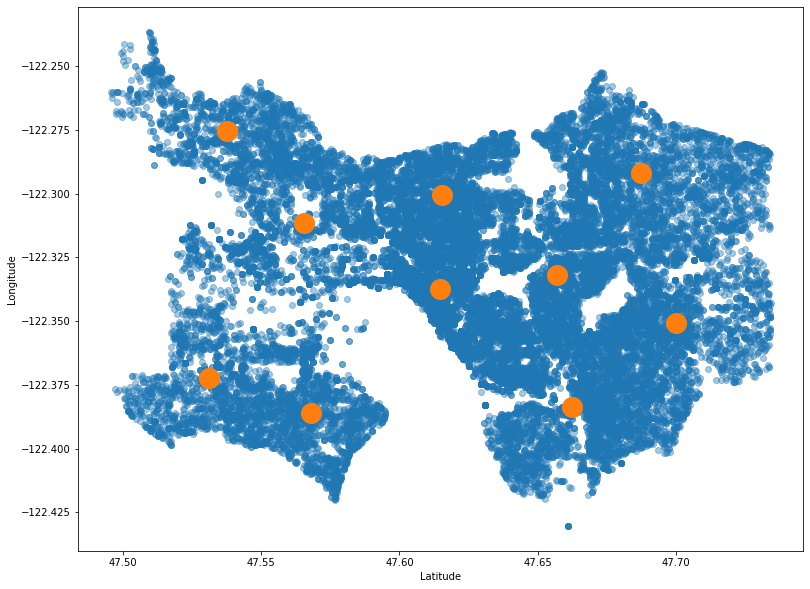

In [10]:
fig,ax1=plt.subplots(figsize=(13,10))
ax1.scatter(train_Location.Latitude,train_Location.Longitude,alpha=0.4,label='samples')
ax1.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label='centers',s=400)
ax1.set_ylabel('Longitude')
ax1.set_xlabel('Latitude')

Text(0.5, 0, 'Latitude')

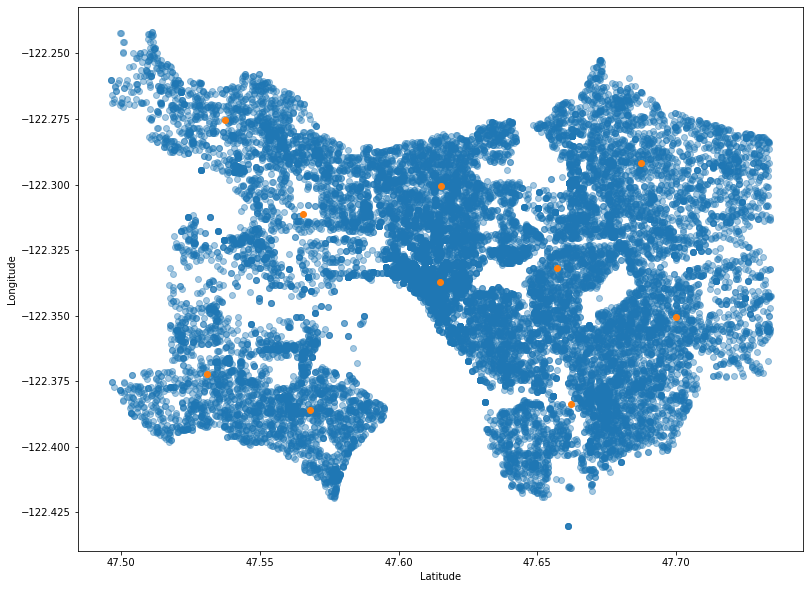

In [11]:
fig,ax1=plt.subplots(figsize=(13,10))
ax1.scatter(test_Location.Latitude,test_Location.Longitude,alpha=0.4,label='samples')
ax1.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label='centers')
ax1.set_ylabel('Longitude')
ax1.set_xlabel('Latitude')

In [12]:
kmean_feats=pd.DataFrame(kmeans.fit_transform(train_Location[['Latitude','Longitude']].values),columns=['gspatial_' + str(i) for i in range(clusters)])
kmean_feats_test=pd.DataFrame(kmeans.fit_transform(test_Location[['Latitude','Longitude']].values),columns=['gspatial_' + str(i) for i in range(clusters)])

In [13]:
kmean_feats

,gspatial_0,gspatial_1,gspatial_2,gspatial_3,gspatial_4,gspatial_5,gspatial_6,gspatial_7,gspatial_8,gspatial_9
0,0.095233,0.028830,0.068724,0.028037,0.023626,0.118011,0.108603,0.071717,0.070263,0.057883
1,0.058398,0.111416,0.146573,0.098203,0.140750,0.021202,0.082588,0.064709,0.181648,0.180689
2,0.073879,0.037976,0.059831,0.009244,0.033504,0.099254,0.106462,0.064122,0.076973,0.078162
3,0.063367,0.034457,0.086877,0.021613,0.062116,0.077553,0.078250,0.034154,0.107165,0.099383
4,0.152440,0.092536,0.077029,0.092503,0.050042,0.182253,0.173884,0.140441,0.031052,0.033807
...,...,...,...,...,...,...,...,...,...,...
33513,0.099542,0.066299,0.147289,0.081264,0.115553,0.086536,0.017827,0.027904,0.162301,0.137254
33514,0.091750,0.022466,0.110437,0.045284,0.072678,0.097115,0.059617,0.030687,0.119346,0.094553
33515,0.157230,0.064930,0.117419,0.090033,0.066707,0.175063,0.133106,0.114127,0.089063,0.030288
33516,0.107706,0.069259,0.153419,0.087174,0.119771,0.094275,0.012356,0.035414,0.166506,0.138708


In [14]:
kmean_feats=pd.DataFrame(kmeans.fit_transform(train_Location[['Latitude','Longitude']].values),index=np.unique(np.where(train_df[['Longitude','Latitude']].notna())),columns=['gspatial_' + str(i) for i in range(clusters)])
train_df=pd.concat([train_df,kmean_feats],axis=1)
train_df.isna().sum()

Application/Permit Number              0
Permit Type                            0
Address                                0
Description                            0
Action Type                            0
Work Type                              0
Applicant Name                         0
Application Date                    6939
Issue Date                         10624
Final Date                         17851
Expiration Date                    10569
Status                                 0
Contractor                             0
Permit and Complaint Status URL        0
Master Use Permit                      0
Latitude                              21
Longitude                             21
Location                               0
Category                               0
gspatial_0                            21
gspatial_1                            21
gspatial_2                            21
gspatial_3                            21
gspatial_4                            21
gspatial_5      

In [15]:
kmean_feats_test=pd.DataFrame(kmeans.fit_transform(test_Location[['Latitude','Longitude']].values),index=np.unique(np.where(test_df[['Longitude','Latitude']].notna())),columns=['gspatial_' + str(i) for i in range(clusters)])
test_df=pd.concat([test_df,kmean_feats_test],axis=1)
test_df.isna().sum()

Application/Permit Number              0
Permit Type                            0
Address                                0
Description                            0
Action Type                            0
Work Type                              0
Applicant Name                         0
Application Date                    4497
Issue Date                          6941
Final Date                         11961
Expiration Date                     6915
Status                                 0
Contractor                             0
Permit and Complaint Status URL        0
Master Use Permit                      0
Latitude                              16
Longitude                             16
Location                               0
gspatial_0                            16
gspatial_1                            16
gspatial_2                            16
gspatial_3                            16
gspatial_4                            16
gspatial_5                            16
gspatial_6      

## folium to visualize

In [16]:
# colordict = {0: 'lightblue', 1: 'lightgreen', 2: 'orange', 3: 'red'}
# colordict[0]

# train_Location
# from IPython.core.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 44em; width:75em}</style>"))

In [17]:
# import folium

# m=folium.Map(location=[train_Location['Latitude'].mean(),train_Location['Longitude'].mean()],zoom_start=5,tiles='Stamen toner')

# for _,row in (train_Location[:100].iterrows()):
#     folium.CircleMarker([row.Latitude,row.Longitude],
#     radius=5,
#     color='orange',
#     fill=True,
#     fill_color='orange').add_to(m)
# m

In [18]:
# for _,row in (train_Location[101:300].iterrows()):
#     folium.CircleMarker([row.Latitude,row.Longitude],
#     radius=5,
#     color='orange',
#     fill=True,
#     fill_color='orange').add_to(m)
# m

In [19]:

# for _,row in (train_Location[ 400:700].iterrows()):
#     folium.CircleMarker([row.Latitude,row.Longitude],
#     radius=5,
#     color='orange',
#     fill=True,
#     fill_color='orange').add_to(m)
# m

In [20]:

# for _,row in (train_Location[ 700:1100].iterrows()):
#     folium.CircleMarker([row.Latitude,row.Longitude],
#     radius=5,
#     color='orange',
#     fill=True,
#     fill_color='orange').add_to(m)
# m

## DBScan and Optic Clustering to make it Better

In [21]:
# from sklearn.cluster import DBSCAN
# kms_per_radian = 63.0088
# epsilon = 5 / kms_per_radian
# db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine',n_job).fit(np.radians(train_Location[:10]))
# cluster_labels = db.labels_
# num_clusters = len(set(cluster_labels))
# clusters = pd.Series([train_Location{:10}[cluster_labels == n] for n in range(num_clusters)])
# print('Number of clusters: {}'.format(num_clusters))


## 2.3 Date Time conversion

In [22]:
print("\nCreate Day Variables")

train_df['Application Date'] = pd.to_datetime(train_df['Application Date'], format='%Y-%m-%d')
train_df['Issue Date'] = pd.to_datetime(train_df['Issue Date'], format='%Y-%m-%d')
train_df['Final Date'] = pd.to_datetime(train_df['Final Date'], format='%Y-%m-%d')
train_df['Expiration Date'] = pd.to_datetime(train_df['Expiration Date'], format='%Y-%m-%d')
    
    
train_df['App_day'] = train_df['Application Date'].dt.day
train_df['Issue_Day'] = train_df['Issue Date'].dt.day
train_df['Final_Day'] = train_df['Final Date'].dt.day
train_df['Exp_Day']   = train_df['Expiration Date'].dt.day

train_df['App_week'] = train_df['Application Date'].dt.week
train_df['Issue_week'] = train_df['Issue Date'].dt.week
train_df['Final_week'] = train_df['Final Date'].dt.week
train_df['Exp_week']   = train_df['Expiration Date'].dt.week
train_df.isna().sum()   


Create Day Variables


<ipython-input-22-c8ade5253844>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['App_week'] = train_df['Application Date'].dt.week
<ipython-input-22-c8ade5253844>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['Issue_week'] = train_df['Issue Date'].dt.week
<ipython-input-22-c8ade5253844>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['Final_week'] = train_df['Final Date'].dt.week
<ipython-input-22-c8ade5253844>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['Exp_week']   = train_df['Expiration Date'].dt.week


Application/Permit Number              0
Permit Type                            0
Address                                0
Description                            0
Action Type                            0
Work Type                              0
Applicant Name                         0
Application Date                    6939
Issue Date                         10624
Final Date                         17851
Expiration Date                    10569
Status                                 0
Contractor                             0
Permit and Complaint Status URL        0
Master Use Permit                      0
Latitude                              21
Longitude                             21
Location                               0
Category                               0
gspatial_0                            21
gspatial_1                            21
gspatial_2                            21
gspatial_3                            21
gspatial_4                            21
gspatial_5      

In [23]:
train_df[date_cols]

,Application Date,Issue Date,Final Date,Expiration Date
0,2018-01-16,2018-01-16,NaT,2019-07-16
1,2015-02-13,2015-04-16,2016-11-15,2016-10-16
2,2014-09-04,2014-09-04,2015-11-20,2016-03-04
3,NaT,NaT,NaT,NaT
4,2013-05-02,2013-12-19,2015-05-14,2015-06-19
...,...,...,...,...
33534,NaT,NaT,NaT,NaT
33535,2014-06-04,2014-09-10,2015-09-01,2016-03-10
33536,2014-10-08,2014-12-05,2015-09-09,2016-06-05
33537,NaT,NaT,NaT,NaT


In [24]:

test_df['Application Date'] = pd.to_datetime(test_df['Application Date'], format='%Y-%m-%d')
test_df['Issue Date'] = pd.to_datetime(test_df['Issue Date'], format='%Y-%m-%d')
test_df['Final Date'] = pd.to_datetime(test_df['Final Date'], format='%Y-%m-%d')
test_df['Expiration Date'] = pd.to_datetime(test_df['Expiration Date'], format='%Y-%m-%d')

test_df['App_day'] = test_df['Application Date'].dt.day
test_df['Issue_Day'] = test_df['Issue Date'].dt.day
test_df['Final_Day'] = test_df['Final Date'].dt.day
test_df['Exp_Day'] = test_df['Expiration Date'].dt.day

test_df['App_week'] = test_df['Application Date'].dt.week
test_df['Issue_week'] = test_df['Issue Date'].dt.week
test_df['Final_week'] = test_df['Final Date'].dt.week
test_df['Exp_week'] = test_df['Expiration Date'].dt.week
test_df.isna().sum()   

<ipython-input-24-fa482ddcd1ab>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['App_week'] = test_df['Application Date'].dt.week
<ipython-input-24-fa482ddcd1ab>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['Issue_week'] = test_df['Issue Date'].dt.week
<ipython-input-24-fa482ddcd1ab>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['Final_week'] = test_df['Final Date'].dt.week
<ipython-input-24-fa482ddcd1ab>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['Exp_week'] = test_df['Expiration Date'].dt.week


Application/Permit Number              0
Permit Type                            0
Address                                0
Description                            0
Action Type                            0
Work Type                              0
Applicant Name                         0
Application Date                    4497
Issue Date                          6941
Final Date                         11961
Expiration Date                     6915
Status                                 0
Contractor                             0
Permit and Complaint Status URL        0
Master Use Permit                      0
Latitude                              16
Longitude                             16
Location                               0
gspatial_0                            16
gspatial_1                            16
gspatial_2                            16
gspatial_3                            16
gspatial_4                            16
gspatial_5                            16
gspatial_6      

In [25]:
train_df[date_cols]

,Application Date,Issue Date,Final Date,Expiration Date
0,2018-01-16,2018-01-16,NaT,2019-07-16
1,2015-02-13,2015-04-16,2016-11-15,2016-10-16
2,2014-09-04,2014-09-04,2015-11-20,2016-03-04
3,NaT,NaT,NaT,NaT
4,2013-05-02,2013-12-19,2015-05-14,2015-06-19
...,...,...,...,...
33534,NaT,NaT,NaT,NaT
33535,2014-06-04,2014-09-10,2015-09-01,2016-03-10
33536,2014-10-08,2014-12-05,2015-09-09,2016-06-05
33537,NaT,NaT,NaT,NaT


## 2.4 Dropping unwanted 

In [26]:
date_cols

['Application Date', 'Issue Date', 'Final Date', 'Expiration Date']

In [27]:
train_df=train_df.drop(columns=['Permit and Complaint Status URL'])
# train_df=train_df.drop(columns=['Applicant Name'])
train_df=train_df.drop(columns=date_cols)

train_df=train_df.drop(columns=['Latitude','Longitude','Address','Location'])
train_df.isna().sum()

test_df=test_df.drop(columns=['Permit and Complaint Status URL'])
# test_df=test_df.drop(columns=['Applicant Name'])

test_df=test_df.drop(columns=date_cols)
test_df=test_df.drop(columns=['Latitude','Longitude','Address','Location'])
test_df.isna().sum()

Application/Permit Number        0
Permit Type                      0
Description                      0
Action Type                      0
Work Type                        0
Applicant Name                   0
Status                           0
Contractor                       0
Master Use Permit                0
gspatial_0                      16
gspatial_1                      16
gspatial_2                      16
gspatial_3                      16
gspatial_4                      16
gspatial_5                      16
gspatial_6                      16
gspatial_7                      16
gspatial_8                      16
gspatial_9                      16
App_day                       4497
Issue_Day                     6941
Final_Day                    11961
Exp_Day                       6915
App_week                      4497
Issue_week                    6941
Final_week                   11961
Exp_week                      6915
dtype: int64

In [28]:
for i in range(0,clusters):
    train_df['gspatial_'+ str(i)]=train_df['gspatial_'+ str(i)].fillna(-999)
day_week_cols=['App_day','Issue_Day','Final_Day','Exp_Day','App_week','Issue_week','Final_week','Exp_week']
for col in day_week_cols:
    train_df[col]=train_df[col].fillna(-999)

train_df.isna().sum()      

for i in range(0,clusters):
    test_df['gspatial_'+ str(i)]=test_df['gspatial_'+ str(i)].fillna(-999)
day_week_cols=['App_day','Issue_Day','Final_Day','Exp_Day','App_week','Issue_week','Final_week','Exp_week']
for col in day_week_cols:
    test_df[col]=test_df[col].fillna(-999)

test_df.isna().sum()   

Application/Permit Number    0
Permit Type                  0
Description                  0
Action Type                  0
Work Type                    0
Applicant Name               0
Status                       0
Contractor                   0
Master Use Permit            0
gspatial_0                   0
gspatial_1                   0
gspatial_2                   0
gspatial_3                   0
gspatial_4                   0
gspatial_5                   0
gspatial_6                   0
gspatial_7                   0
gspatial_8                   0
gspatial_9                   0
App_day                      0
Issue_Day                    0
Final_Day                    0
Exp_Day                      0
App_week                     0
Issue_week                   0
Final_week                   0
Exp_week                     0
dtype: int64

## 2.5 Encoding

In [29]:
num_col=[]
obj_col=[]

num_col = numerical_cols+['gspatial_'+ str(i) for i in range(0,clusters)]+day_week_cols
obj_col=[col for col in train_df if col not in num_col]

obj_col.remove('Description')
obj_col.remove('Category')

# obj_col.remove('Applicant Name')
# obj_col.remove('Status')


In [30]:
# train_df=pd.concat([train_df,categorical_features],axis=1)

## 2.6 Text Preprocessing

In [31]:
#### train
train_df['Description'] = train_df['Description'].fillna('')
train_df['clean_description']=[' '.join([w for w in x.lower().split() if w not in stop]) for x in train_df['Description'].tolist()]
##### test
test_df['Description'] = test_df['Description'].fillna('')
test_df['clean_description']=[' '.join([w for w in x.lower().split() if w not in stop]) for x in test_df['Description'].tolist()]

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '',string.punctuation))

def lemmatize(text):
    tokens=regexp_tokenize(text,pattern='\s+',gaps=True) #https://towardsdatascience.com/benchmarking-python-nlp-tokenizers-3ac4735100c5
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
###### Train
train_df['clean_description']=train_df['clean_description'].apply(lemmatize)
train_df['clean_description']=train_df['clean_description'].apply(remove_punctuation)
# print(train_df['clean_description'])

#### Test
test_df['clean_description']=test_df['clean_description'].apply(lemmatize)
test_df['clean_description']=test_df['clean_description'].apply(remove_punctuation)
# print(train_df['clean_description'])

train_df=train_df.drop('Description',axis=1)
test_df=test_df.drop('Description',axis=1)    

## 2.7 Tfidf Text features

In [32]:
# pip install texthero
# import texthero as hero

# df['tfidf'] = hero.tfidf(df['sent'])

In [33]:
########## singular column
text_cols=['clean_description']
text_cols
from sklearn.feature_extraction.text import TfidfVectorizer
def text_features_uni(df):
    for cols in text_cols:
        
        df[cols] = df[cols].astype(str) 
        df[cols] = df[cols].astype(str).fillna('') # FILL NA
        
        df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
        df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
        
        df[cols +'_nos_removed']=df[cols].str.replace('\d+', '')
        

        df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
        df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
        df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    return df
    

    print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")

train_df=text_features_uni(train_df)
test_df=text_features_uni(test_df)

train_df=train_df.drop('clean_description',axis=1)
test_df=test_df.drop('clean_description',axis=1)


<ipython-input-33-100c72c610da>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[cols +'_nos_removed']=df[cols].str.replace('\d+', '')


In [34]:
train_df.columns

Index(['Application/Permit Number', 'Permit Type', 'Action Type', 'Work Type',
       'Applicant Name', 'Status', 'Contractor', 'Master Use Permit',
       'Category', 'gspatial_0', 'gspatial_1', 'gspatial_2', 'gspatial_3',
       'gspatial_4', 'gspatial_5', 'gspatial_6', 'gspatial_7', 'gspatial_8',
       'gspatial_9', 'App_day', 'Issue_Day', 'Final_Day', 'Exp_Day',
       'App_week', 'Issue_week', 'Final_week', 'Exp_week',
       'clean_description_nos_removed', 'clean_description_num_words',
       'clean_description_num_unique_words',
       'clean_description_words_vs_unique'],
      dtype='object')

In [35]:
# train_df['Application/Permit Number']=le.fit_transform(train_df['Application/Permit Number'])
# obj_col.remove('Application/Permit Number')
# test_df['Application/Permit Number']=le.fit_transform(test_df['Application/Permit Number'])
train_df['clean_description_words_vs_unique']=train_df['clean_description_words_vs_unique'].fillna(0)
test_df['clean_description_words_vs_unique']=test_df['clean_description_words_vs_unique'].fillna(0)
# print(test_df.isna().sum())
# print(train_df.isna().sum())

In [36]:
print(len(train_df.columns))
print(len(test_df.columns))
print(obj_col)

31
30
['Application/Permit Number', 'Permit Type', 'Action Type', 'Work Type', 'Applicant Name', 'Status', 'Contractor']


## 2.8 Data Split

In [37]:
from sklearn.model_selection import train_test_split
y=train_df['Category']
X=train_df.drop('Category',axis=1)
y=le.fit_transform(y)

In [38]:
X_train, X_test, y_train, y_test= train_test_split(X,y,shuffle=True,test_size=0.25)

In [39]:
# import lightgbm
# import time
import catboost
from catboost import CatBoostClassifier,Pool
from catboost.utils import get_gpu_device_count
print('\n%i GPU devices available' % get_gpu_device_count())



1 GPU devices available


# 3 Text Features and categorical Features in Catboost

issue while CPU and AUC
CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/libs/train_lib/train_model.cpp:689: Feature calcers are not supported in CPU training yet

issue while GPU and AUC

warning AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time

issue: CatBoostError: c:/program files (x86)/go 
agent/pipelines/buildmaster/catboost.git/catboost/cuda/targets/gpu_metrics.cpp:662: Eval metric should have a single value. Metric MultiClass provides a value for each class, thus it cannot be used as a single value to select best iteration or to detect overfitting. If you just want to look on the values of this metric use custom_metric parameter.


In [40]:
catboost_model=CatBoostClassifier(iterations=1500,
                                  depth=10,
                                  learning_rate=0.02,
                                  eval_metric='Accuracy',
                                  loss_function='MultiClass',
                                  task_type="GPU")

train_pool=Pool(X_train,y_train,cat_features=obj_col,text_features=['clean_description_nos_removed'])
test_pool=Pool(X_test,y_test,cat_features=obj_col,text_features=['clean_description_nos_removed'])
catboost_model.fit(X_train,y_train,cat_features=obj_col,text_features=['clean_description_nos_removed'],eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8668999	test: 0.8639237	best: 0.8639237 (0)	total: 173ms	remaining: 4m 19s
1:	learn: 0.8689274	test: 0.8719141	best: 0.8719141 (1)	total: 278ms	remaining: 3m 27s
2:	learn: 0.8687286	test: 0.8727490	best: 0.8727490 (2)	total: 389ms	remaining: 3m 14s
3:	learn: 0.8670987	test: 0.8723912	best: 0.8727490 (2)	total: 506ms	remaining: 3m 9s
4:	learn: 0.8675360	test: 0.8721527	best: 0.8727490 (2)	total: 610ms	remaining: 3m 2s
5:	learn: 0.8690467	test: 0.8738223	best: 0.8738223 (5)	total: 712ms	remaining: 2m 57s
6:	learn: 0.8693647	test: 0.8732260	best: 0.8738223 (5)	total: 821ms	remaining: 2m 55s
7:	learn: 0.8690069	test: 0.8737030	best: 0.8738223 (5)	total: 926ms	remaining: 2m 52s
8:	learn: 0.8688479	test: 0.8739416	best: 0.8739416 (8)	total: 1.05s	remaining: 2m 53s
9:	learn: 0.8698815	test: 0.8745379	best: 0.8745379 (9)	total: 1.19s	remaining: 2m 56s
10:	learn: 0.8697623	test: 0.8746571	best: 0.8746571 (10)	total: 1.31s	remaining: 2m 57s
11:	learn: 0.8703188	test: 0.8742993	best: 

93:	learn: 0.8834380	test: 0.8853906	best: 0.8853906 (92)	total: 10.4s	remaining: 2m 35s
94:	learn: 0.8836368	test: 0.8855098	best: 0.8855098 (94)	total: 10.5s	remaining: 2m 35s
95:	learn: 0.8839548	test: 0.8853906	best: 0.8855098 (94)	total: 10.6s	remaining: 2m 34s
96:	learn: 0.8840343	test: 0.8852713	best: 0.8855098 (94)	total: 10.7s	remaining: 2m 35s
97:	learn: 0.8841139	test: 0.8852713	best: 0.8855098 (94)	total: 10.9s	remaining: 2m 35s
98:	learn: 0.8840741	test: 0.8852713	best: 0.8855098 (94)	total: 11s	remaining: 2m 35s
99:	learn: 0.8839946	test: 0.8853906	best: 0.8855098 (94)	total: 11.1s	remaining: 2m 35s
100:	learn: 0.8842331	test: 0.8857484	best: 0.8857484 (100)	total: 11.2s	remaining: 2m 35s
101:	learn: 0.8845512	test: 0.8856291	best: 0.8857484 (100)	total: 11.3s	remaining: 2m 35s
102:	learn: 0.8845512	test: 0.8859869	best: 0.8859869 (102)	total: 11.4s	remaining: 2m 34s
103:	learn: 0.8843921	test: 0.8858676	best: 0.8859869 (102)	total: 11.5s	remaining: 2m 34s
104:	learn: 0.8

184:	learn: 0.8927010	test: 0.8896840	best: 0.8896840 (170)	total: 19.5s	remaining: 2m 18s
185:	learn: 0.8928997	test: 0.8898032	best: 0.8898032 (185)	total: 19.6s	remaining: 2m 18s
186:	learn: 0.8928202	test: 0.8901610	best: 0.8901610 (186)	total: 19.7s	remaining: 2m 18s
187:	learn: 0.8929395	test: 0.8898032	best: 0.8901610 (186)	total: 19.8s	remaining: 2m 17s
188:	learn: 0.8929792	test: 0.8899225	best: 0.8901610 (186)	total: 19.8s	remaining: 2m 17s
189:	learn: 0.8930190	test: 0.8901610	best: 0.8901610 (186)	total: 19.9s	remaining: 2m 17s
190:	learn: 0.8932178	test: 0.8902803	best: 0.8902803 (190)	total: 20s	remaining: 2m 17s
191:	learn: 0.8931780	test: 0.8902803	best: 0.8902803 (190)	total: 20.1s	remaining: 2m 16s
192:	learn: 0.8930190	test: 0.8901610	best: 0.8902803 (190)	total: 20.2s	remaining: 2m 16s
193:	learn: 0.8930588	test: 0.8901610	best: 0.8902803 (190)	total: 20.3s	remaining: 2m 16s
194:	learn: 0.8930190	test: 0.8902803	best: 0.8902803 (190)	total: 20.4s	remaining: 2m 16s
1

277:	learn: 0.8971933	test: 0.8919499	best: 0.8920692 (275)	total: 27s	remaining: 1m 58s
278:	learn: 0.8971535	test: 0.8920692	best: 0.8920692 (275)	total: 27.1s	remaining: 1m 58s
279:	learn: 0.8972330	test: 0.8920692	best: 0.8920692 (275)	total: 27.1s	remaining: 1m 58s
280:	learn: 0.8972728	test: 0.8920692	best: 0.8920692 (275)	total: 27.2s	remaining: 1m 58s
281:	learn: 0.8971535	test: 0.8917114	best: 0.8920692 (275)	total: 27.3s	remaining: 1m 57s
282:	learn: 0.8973523	test: 0.8918306	best: 0.8920692 (275)	total: 27.4s	remaining: 1m 57s
283:	learn: 0.8973523	test: 0.8918306	best: 0.8920692 (275)	total: 27.4s	remaining: 1m 57s
284:	learn: 0.8974318	test: 0.8919499	best: 0.8920692 (275)	total: 27.5s	remaining: 1m 57s
285:	learn: 0.8975511	test: 0.8920692	best: 0.8920692 (275)	total: 27.6s	remaining: 1m 57s
286:	learn: 0.8975908	test: 0.8920692	best: 0.8920692 (275)	total: 27.6s	remaining: 1m 56s
287:	learn: 0.8976306	test: 0.8920692	best: 0.8920692 (275)	total: 27.7s	remaining: 1m 56s
2

370:	learn: 0.9015664	test: 0.8938581	best: 0.8938581 (370)	total: 34.1s	remaining: 1m 43s
371:	learn: 0.9014868	test: 0.8939773	best: 0.8939773 (371)	total: 34.1s	remaining: 1m 43s
372:	learn: 0.9016061	test: 0.8937388	best: 0.8939773 (371)	total: 34.2s	remaining: 1m 43s
373:	learn: 0.9018446	test: 0.8938581	best: 0.8939773 (371)	total: 34.3s	remaining: 1m 43s
374:	learn: 0.9018844	test: 0.8937388	best: 0.8939773 (371)	total: 34.4s	remaining: 1m 43s
375:	learn: 0.9018844	test: 0.8938581	best: 0.8939773 (371)	total: 34.4s	remaining: 1m 42s
376:	learn: 0.9018446	test: 0.8938581	best: 0.8939773 (371)	total: 34.5s	remaining: 1m 42s
377:	learn: 0.9020832	test: 0.8942159	best: 0.8942159 (377)	total: 34.6s	remaining: 1m 42s
378:	learn: 0.9020037	test: 0.8944544	best: 0.8944544 (378)	total: 34.7s	remaining: 1m 42s
379:	learn: 0.9021627	test: 0.8943351	best: 0.8944544 (378)	total: 34.7s	remaining: 1m 42s
380:	learn: 0.9021229	test: 0.8943351	best: 0.8944544 (378)	total: 34.8s	remaining: 1m 42s

463:	learn: 0.9062177	test: 0.8951699	best: 0.8951699 (441)	total: 41s	remaining: 1m 31s
464:	learn: 0.9060984	test: 0.8952892	best: 0.8952892 (464)	total: 41.1s	remaining: 1m 31s
465:	learn: 0.9060984	test: 0.8952892	best: 0.8952892 (464)	total: 41.2s	remaining: 1m 31s
466:	learn: 0.9061779	test: 0.8952892	best: 0.8952892 (464)	total: 41.3s	remaining: 1m 31s
467:	learn: 0.9061382	test: 0.8951699	best: 0.8952892 (464)	total: 41.3s	remaining: 1m 31s
468:	learn: 0.9060984	test: 0.8951699	best: 0.8952892 (464)	total: 41.4s	remaining: 1m 31s
469:	learn: 0.9061779	test: 0.8950507	best: 0.8952892 (464)	total: 41.5s	remaining: 1m 30s
470:	learn: 0.9061779	test: 0.8949314	best: 0.8952892 (464)	total: 41.5s	remaining: 1m 30s
471:	learn: 0.9063370	test: 0.8949314	best: 0.8952892 (464)	total: 41.6s	remaining: 1m 30s
472:	learn: 0.9064165	test: 0.8949314	best: 0.8952892 (464)	total: 41.7s	remaining: 1m 30s
473:	learn: 0.9064165	test: 0.8949314	best: 0.8952892 (464)	total: 41.8s	remaining: 1m 30s
4

556:	learn: 0.9087223	test: 0.8952892	best: 0.8955277 (532)	total: 48.2s	remaining: 1m 21s
557:	learn: 0.9086825	test: 0.8952892	best: 0.8955277 (532)	total: 48.3s	remaining: 1m 21s
558:	learn: 0.9086428	test: 0.8952892	best: 0.8955277 (532)	total: 48.4s	remaining: 1m 21s
559:	learn: 0.9086428	test: 0.8952892	best: 0.8955277 (532)	total: 48.4s	remaining: 1m 21s
560:	learn: 0.9088018	test: 0.8952892	best: 0.8955277 (532)	total: 48.5s	remaining: 1m 21s
561:	learn: 0.9088415	test: 0.8954085	best: 0.8955277 (532)	total: 48.6s	remaining: 1m 21s
562:	learn: 0.9088415	test: 0.8954085	best: 0.8955277 (532)	total: 48.7s	remaining: 1m 20s
563:	learn: 0.9088415	test: 0.8951699	best: 0.8955277 (532)	total: 48.8s	remaining: 1m 20s
564:	learn: 0.9088018	test: 0.8952892	best: 0.8955277 (532)	total: 48.8s	remaining: 1m 20s
565:	learn: 0.9088018	test: 0.8951699	best: 0.8955277 (532)	total: 48.9s	remaining: 1m 20s
566:	learn: 0.9088415	test: 0.8952892	best: 0.8955277 (532)	total: 49s	remaining: 1m 20s
5

647:	learn: 0.9122605	test: 0.8960048	best: 0.8961240 (646)	total: 55s	remaining: 1m 12s
648:	learn: 0.9122207	test: 0.8961240	best: 0.8961240 (646)	total: 55.1s	remaining: 1m 12s
649:	learn: 0.9122605	test: 0.8961240	best: 0.8961240 (646)	total: 55.2s	remaining: 1m 12s
650:	learn: 0.9122207	test: 0.8961240	best: 0.8961240 (646)	total: 55.3s	remaining: 1m 12s
651:	learn: 0.9123002	test: 0.8961240	best: 0.8961240 (646)	total: 55.3s	remaining: 1m 11s
652:	learn: 0.9123797	test: 0.8961240	best: 0.8961240 (646)	total: 55.4s	remaining: 1m 11s
653:	learn: 0.9124195	test: 0.8960048	best: 0.8961240 (646)	total: 55.5s	remaining: 1m 11s
654:	learn: 0.9126183	test: 0.8958855	best: 0.8961240 (646)	total: 55.6s	remaining: 1m 11s
655:	learn: 0.9126978	test: 0.8957662	best: 0.8961240 (646)	total: 55.6s	remaining: 1m 11s
656:	learn: 0.9127375	test: 0.8957662	best: 0.8961240 (646)	total: 55.7s	remaining: 1m 11s
657:	learn: 0.9128568	test: 0.8957662	best: 0.8961240 (646)	total: 55.8s	remaining: 1m 11s
6

741:	learn: 0.9150831	test: 0.8970781	best: 0.8970781 (737)	total: 1m 2s	remaining: 1m 3s
742:	learn: 0.9149638	test: 0.8971974	best: 0.8971974 (742)	total: 1m 2s	remaining: 1m 3s
743:	learn: 0.9150433	test: 0.8971974	best: 0.8971974 (742)	total: 1m 2s	remaining: 1m 3s
744:	learn: 0.9151626	test: 0.8970781	best: 0.8971974 (742)	total: 1m 2s	remaining: 1m 3s
745:	learn: 0.9151228	test: 0.8970781	best: 0.8971974 (742)	total: 1m 2s	remaining: 1m 3s
746:	learn: 0.9152421	test: 0.8973166	best: 0.8973166 (746)	total: 1m 2s	remaining: 1m 2s
747:	learn: 0.9154806	test: 0.8970781	best: 0.8973166 (746)	total: 1m 2s	remaining: 1m 2s
748:	learn: 0.9156397	test: 0.8969589	best: 0.8973166 (746)	total: 1m 2s	remaining: 1m 2s
749:	learn: 0.9155999	test: 0.8970781	best: 0.8973166 (746)	total: 1m 2s	remaining: 1m 2s
750:	learn: 0.9156794	test: 0.8969589	best: 0.8973166 (746)	total: 1m 2s	remaining: 1m 2s
751:	learn: 0.9157987	test: 0.8968396	best: 0.8973166 (746)	total: 1m 2s	remaining: 1m 2s
752:	learn

834:	learn: 0.9182237	test: 0.8973166	best: 0.8974359 (765)	total: 1m 8s	remaining: 54.9s
835:	learn: 0.9181442	test: 0.8971974	best: 0.8974359 (765)	total: 1m 9s	remaining: 54.8s
836:	learn: 0.9181045	test: 0.8971974	best: 0.8974359 (765)	total: 1m 9s	remaining: 54.8s
837:	learn: 0.9181840	test: 0.8973166	best: 0.8974359 (765)	total: 1m 9s	remaining: 54.7s
838:	learn: 0.9183430	test: 0.8975552	best: 0.8975552 (838)	total: 1m 9s	remaining: 54.6s
839:	learn: 0.9183033	test: 0.8975552	best: 0.8975552 (838)	total: 1m 9s	remaining: 54.5s
840:	learn: 0.9183033	test: 0.8975552	best: 0.8975552 (838)	total: 1m 9s	remaining: 54.4s
841:	learn: 0.9183430	test: 0.8975552	best: 0.8975552 (838)	total: 1m 9s	remaining: 54.3s
842:	learn: 0.9185020	test: 0.8975552	best: 0.8975552 (838)	total: 1m 9s	remaining: 54.2s
843:	learn: 0.9185418	test: 0.8974359	best: 0.8975552 (838)	total: 1m 9s	remaining: 54.1s
844:	learn: 0.9184623	test: 0.8975552	best: 0.8975552 (838)	total: 1m 9s	remaining: 54s
845:	learn: 

926:	learn: 0.9209271	test: 0.8973166	best: 0.8976744 (909)	total: 1m 15s	remaining: 46.8s
927:	learn: 0.9208078	test: 0.8973166	best: 0.8976744 (909)	total: 1m 15s	remaining: 46.7s
928:	learn: 0.9208873	test: 0.8973166	best: 0.8976744 (909)	total: 1m 15s	remaining: 46.7s
929:	learn: 0.9210066	test: 0.8974359	best: 0.8976744 (909)	total: 1m 15s	remaining: 46.6s
930:	learn: 0.9210066	test: 0.8974359	best: 0.8976744 (909)	total: 1m 16s	remaining: 46.5s
931:	learn: 0.9211259	test: 0.8973166	best: 0.8976744 (909)	total: 1m 16s	remaining: 46.4s
932:	learn: 0.9212054	test: 0.8974359	best: 0.8976744 (909)	total: 1m 16s	remaining: 46.3s
933:	learn: 0.9212849	test: 0.8974359	best: 0.8976744 (909)	total: 1m 16s	remaining: 46.2s
934:	learn: 0.9212849	test: 0.8973166	best: 0.8976744 (909)	total: 1m 16s	remaining: 46.1s
935:	learn: 0.9213246	test: 0.8973166	best: 0.8976744 (909)	total: 1m 16s	remaining: 46s
936:	learn: 0.9214042	test: 0.8976744	best: 0.8976744 (909)	total: 1m 16s	remaining: 46s
937

1017:	learn: 0.9228751	test: 0.8979129	best: 0.8979129 (1007)	total: 1m 22s	remaining: 39.1s
1018:	learn: 0.9228751	test: 0.8979129	best: 0.8979129 (1007)	total: 1m 22s	remaining: 39s
1019:	learn: 0.9228751	test: 0.8979129	best: 0.8979129 (1007)	total: 1m 22s	remaining: 38.9s
1020:	learn: 0.9228751	test: 0.8979129	best: 0.8979129 (1007)	total: 1m 22s	remaining: 38.8s
1021:	learn: 0.9228353	test: 0.8981515	best: 0.8981515 (1021)	total: 1m 22s	remaining: 38.7s
1022:	learn: 0.9228751	test: 0.8981515	best: 0.8981515 (1021)	total: 1m 22s	remaining: 38.6s
1023:	learn: 0.9228353	test: 0.8979129	best: 0.8981515 (1021)	total: 1m 22s	remaining: 38.6s
1024:	learn: 0.9228353	test: 0.8979129	best: 0.8981515 (1021)	total: 1m 23s	remaining: 38.5s
1025:	learn: 0.9228751	test: 0.8979129	best: 0.8981515 (1021)	total: 1m 23s	remaining: 38.4s
1026:	learn: 0.9228751	test: 0.8979129	best: 0.8981515 (1021)	total: 1m 23s	remaining: 38.3s
1027:	learn: 0.9229148	test: 0.8979129	best: 0.8981515 (1021)	total: 1m 

1106:	learn: 0.9252604	test: 0.8988670	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.6s
1107:	learn: 0.9251809	test: 0.8988670	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.5s
1108:	learn: 0.9252206	test: 0.8988670	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.4s
1109:	learn: 0.9251809	test: 0.8987478	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.4s
1110:	learn: 0.9251809	test: 0.8987478	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.3s
1111:	learn: 0.9251809	test: 0.8986285	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.2s
1112:	learn: 0.9251411	test: 0.8986285	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31.1s
1113:	learn: 0.9251809	test: 0.8986285	best: 0.8988670 (1100)	total: 1m 29s	remaining: 31s
1114:	learn: 0.9251809	test: 0.8986285	best: 0.8988670 (1100)	total: 1m 29s	remaining: 30.9s
1115:	learn: 0.9252604	test: 0.8986285	best: 0.8988670 (1100)	total: 1m 29s	remaining: 30.9s
1116:	learn: 0.9253399	test: 0.8987478	best: 0.8988670 (1100)	total: 1m 

1197:	learn: 0.9271686	test: 0.8989863	best: 0.8992248 (1192)	total: 1m 35s	remaining: 24.1s
1198:	learn: 0.9272482	test: 0.8988670	best: 0.8992248 (1192)	total: 1m 35s	remaining: 24s
1199:	learn: 0.9272879	test: 0.8988670	best: 0.8992248 (1192)	total: 1m 35s	remaining: 23.9s
1200:	learn: 0.9272482	test: 0.8988670	best: 0.8992248 (1192)	total: 1m 35s	remaining: 23.9s
1201:	learn: 0.9273277	test: 0.8988670	best: 0.8992248 (1192)	total: 1m 35s	remaining: 23.8s
1202:	learn: 0.9274072	test: 0.8989863	best: 0.8992248 (1192)	total: 1m 36s	remaining: 23.7s
1203:	learn: 0.9273674	test: 0.8988670	best: 0.8992248 (1192)	total: 1m 36s	remaining: 23.6s
1204:	learn: 0.9274072	test: 0.8988670	best: 0.8992248 (1192)	total: 1m 36s	remaining: 23.5s
1205:	learn: 0.9274867	test: 0.8989863	best: 0.8992248 (1192)	total: 1m 36s	remaining: 23.5s
1206:	learn: 0.9274867	test: 0.8989863	best: 0.8992248 (1192)	total: 1m 36s	remaining: 23.4s
1207:	learn: 0.9274469	test: 0.8989863	best: 0.8992248 (1192)	total: 1m 

1286:	learn: 0.9289576	test: 0.8995826	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.9s
1287:	learn: 0.9289576	test: 0.8995826	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.8s
1288:	learn: 0.9289576	test: 0.8994633	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.7s
1289:	learn: 0.9289974	test: 0.8994633	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.7s
1290:	learn: 0.9289576	test: 0.8994633	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.6s
1291:	learn: 0.9289974	test: 0.8993441	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.5s
1292:	learn: 0.9289974	test: 0.8993441	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.4s
1293:	learn: 0.9289974	test: 0.8994633	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.3s
1294:	learn: 0.9289974	test: 0.8994633	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.3s
1295:	learn: 0.9290769	test: 0.8993441	best: 0.8995826 (1258)	total: 1m 42s	remaining: 16.2s
1296:	learn: 0.9290769	test: 0.8994633	best: 0.8995826 (1258)	total: 1

1375:	learn: 0.9307466	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.77s
1376:	learn: 0.9307864	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.69s
1377:	learn: 0.9307864	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.61s
1378:	learn: 0.9308261	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.54s
1379:	learn: 0.9308659	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.46s
1380:	learn: 0.9308261	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.38s
1381:	learn: 0.9309056	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.3s
1382:	learn: 0.9308261	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 48s	remaining: 9.22s
1383:	learn: 0.9308261	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 49s	remaining: 9.14s
1384:	learn: 0.9307864	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 49s	remaining: 9.06s
1385:	learn: 0.9307466	test: 0.8991055	best: 0.8995826 (1258)	total: 1m

1464:	learn: 0.9322971	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 54s	remaining: 2.74s
1465:	learn: 0.9322573	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 54s	remaining: 2.67s
1466:	learn: 0.9322573	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 54s	remaining: 2.59s
1467:	learn: 0.9322175	test: 0.8989863	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.51s
1468:	learn: 0.9323368	test: 0.8988670	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.43s
1469:	learn: 0.9323766	test: 0.8988670	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.35s
1470:	learn: 0.9324561	test: 0.8987478	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.27s
1471:	learn: 0.9324958	test: 0.8987478	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.19s
1472:	learn: 0.9324958	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.12s
1473:	learn: 0.9324561	test: 0.8991055	best: 0.8995826 (1258)	total: 1m 55s	remaining: 2.04s
1474:	learn: 0.9324163	test: 0.8991055	best: 0.8995826 (1258)	total: 1

In [41]:
import shap
from catboost.datasets import *
explainer = shap.TreeExplainer(catboost_model)
shap_values=explainer.shap_values(Pool(X,y,cat_features=obj_col,text_features=['clean_description_nos_removed']))

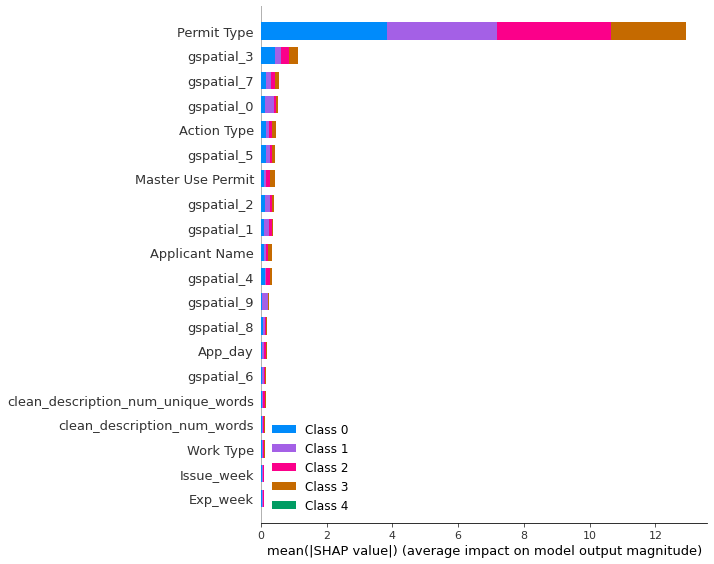

In [42]:
shap.summary_plot(shap_values, X)

In [43]:
print("\n The best score across ALL searched params:\n",
          catboost_model.best_score_)


 The best score across ALL searched params:
 {'learn': {'Accuracy': 0.9327343563647928, 'MultiClass': 0.20697615966893934}, 'validation': {'Accuracy': 0.8995825879546809, 'MultiClass': 0.28601125172368813}}


In [44]:
y_pred=catboost_model.predict(test_df)
y=train_df['Category']
y=le.fit_transform(y)
labels=y_pred.flatten()
test_df['Category']=le.inverse_transform(labels)
catboost_model1=pd.DataFrame(test_df,columns=['Application/Permit Number','Category'])
catboost_model1.to_csv('catsubmission.csv')

### Manual Changes

In [42]:
# catboost_model_1=CatBoostClassifier(iterations=1500,
#                                   depth=10,
#                                   learning_rate=0.001,
#                                   eval_metric='Accuracy',
#                                   loss_function='MultiClass',
#                                   task_type="GPU")

# train_pool=Pool(X_train,y_train,cat_features=obj_col,text_features=['clean_description_nos_removed'])
# test_pool=Pool(X_test,y_test,cat_features=obj_col,text_features=['clean_description_nos_removed'])
# catboost_model_1.fit(X_train,y_train,cat_features=obj_col,text_features=['clean_description_nos_removed'],eval_set=(X_test,y_test),plot=True)


## from Hyperparameter secondDynamic CV Aproach best parameters

In [43]:
# parameters={'nan_mode': 'Min',
#             'gpu_ram_part': 0.95,
#             'eval_metric': 'Accuracy', 
#             'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 15, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'one_hot_max_size': 2, 'devices': '0:1', 'l2_leaf_reg': 7, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False,'max_ctr_complexity': 1, 'gpu_cat_features_storage': 'GpuRam', 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=MinEntropy:Prior=0/1'], 'use_best_model': False, 'class_names': [0, 1, 2, 3, 4], 'random_seed': 0, 'depth': 9, 'ctr_target_border_count': 1, 'has_time': False, 'border_count': 128,'data_partition': 'DocParallel', 'bagging_temperature': 1, 'classes_count': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.7778555750846863, 'text_processing': {'dictionaries': [{'start_token_id': '0', 'occurrence_lower_bound': '5', 'skip_step': '0', 'end_of_word_token_policy': 'Insert', 'token_level_type': 'Word', 'end_of_sentence_token_policy': 'Skip', 'gram_order': '2', 'max_dictionary_size': '50000', 'dictionary_id': 'BiGram'}, {'start_token_id': '0', 'occurrence_lower_bound': '5', 'skip_step': '0', 'end_of_word_token_policy': 'Insert', 'token_level_type': 'Word', 'end_of_sentence_token_policy': 'Skip', 'gram_order': '1', 'max_dictionary_size': '50000', 'dictionary_id': 'Word'}], 'feature_processing': {'default': [{'dictionaries_names': ['BiGram', 'Word'], 'feature_calcers': ['BoW'], 'tokenizers_names': ['Space']}, {'dictionaries_names': ['Word'], 'feature_calcers': ['NaiveBayes'], 'tokenizers_names': ['Space']}]}, 'tokenizers': [{'number_token': '🔢', 'skip_empty': '1', 'number_process_policy': 'LeaveAsIs', 'tokenizer_id': 'Space', 'token_types': ['Number', 'Unknown', 'Word'], 'delimiter': ' ', 'languages': [], 'lemmatizing': '0', 'split_by_set': '0', 'lowercasing': '0', 'subtokens_policy': 'SingleToken', 'separator_type': 'ByDelimiter'}]}, 'score_function': 'Cosine', 'task_type': 'GPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'Bayesian', 'max_leaves': 512, }

In [44]:

# catboost_model_tuned=CatBoostClassifier(**parameters)
# catboost_model_tuned.fit(X_train,y_train,cat_features=obj_col,text_features=['clean_description_nos_removed'],eval_set=(X_test,y_test),plot=True)

In [45]:
# y_pred=catboost_model_tuned.predict(test_df)
# y=train_df['Category']
# y=le.fit_transform(y)
# labels=y_pred.flatten()
# test_df['Category']=le.inverse_transform(labels)
# catboost_model_tune=pd.DataFrame(test_df,columns=['Application/Permit Number','Category'])
# catboost_model_tune.to_csv('catsubmission1.csv')

### Hyperparameter tuning


In [46]:
# parameters = {'depth' : [4,5,6,7,8,9,10],
#                  'learning_rate' : [0.003,0.002,0.001,0.01,0.02,0.03,0.04,0.05],
#                   'iterations'  : [10, 20,30,40,50,60,70,80,90, 100,200,250,300,400,500,600,800]
#              }


In [47]:
# y_1=train_df['Category']
# X_1=train_df.drop('Category',axis=1)
# y_1=le.fit_transform(y)
# X_train, X_test, y_train, y_test= train_test_split(X_1,y_1,shuffle=True,test_size=0.25)

# catboost_model_2=CatBoostClassifier(loss_function='MultiClass',eval_metric='Accuracy',task_type="GPU",cat_features=obj_col,text_features=['clean_description_nos_removed'])
# catboost_model_2.randomized_search(param_distributions=parameters,X=X_train,y=y_train,plot=True)
# print("\n The best score across ALL searched params:\n",
#           catboost_model_2.best_score_)
    


In [48]:
# import shap
# train_pool=Pool(X_train,cat_features=obj_col,text_features=['clean_description_nos_removed'])
# test_pool=Pool(X_test,cat_features=obj_col,text_features=['clean_description_nos_removed'])

# explainer = shap.TreeExplainer(catboost_model_2)
# shap_values=explainer.shap_values(train_pool)
# shap.summary_plot(shap_values,test_pool)

### HyperParameter second Approach

In [49]:
# from scipy.stats import uniform as sp_randFloat
# from scipy.stats import randint as sp_randInt  

# parameters = {'depth'         : sp_randInt(6, 10),
#               'learning_rate' : sp_randFloat(),
#               'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
#               }
# cboost_rs=CatBoostClassifier(iterations=15,loss_function='MultiClass',eval_metric='Accuracy',task_type="GPU",devices='0:1',cat_features=obj_col,text_features=['clean_description_nos_removed'])
# cboost_rs.randomized_search(param_distributions=parameters,X=X_train,y=y_train,plot=True)


In [50]:
# print("\n The best score across ALL searched params:\n",
#           cboost_rs.best_score_)
    
# print("\n The best parameters across ALL searched params:\n",
#           cboost_rs.get_all_params())

In [51]:
# explainer = shap.TreeExplainer(cboost_rs)
# shap_values=explainer.shap_values(train_pool)
# shap.summary_plot(shap_values,test_pool)

## TFIDF text features

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
df1=pd.DataFrame()
train_df_1=pd.DataFrame()
test_df_1=pd.DataFrame()
def tfidf(df):
    v = TfidfVectorizer(max_features=20)
    x= v.fit_transform(df['clean_description_nos_removed'])
    df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
    df = pd.concat([df, df1], axis=1)
    return df

train_df_1=tfidf(train_df)
test_df_1=tfidf(test_df)

train_df_1=train_df_1.drop(columns='clean_description_nos_removed',axis=1)
test_df_1=test_df_1.drop('clean_description_nos_removed',axis=1)


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [53]:
# text_unwanted=['clean_description_num_words','clean_description_num_unique_words','clean_description_words_vs_unique','clean_description_nos_removed']
# for col in text_unwanted:
#     if(col in list(train_df_1.columns.to_list())):
#         train_df_1=train_df_1.drop(columns=col,axis=1)
#         test_df_1=test_df_1.drop(columns=text_unwanted)

In [46]:
from sklearn.model_selection import train_test_split
y=train_df_1['Category']
X=train_df_1.drop('Category',axis=1)
y=le.fit_transform(y)
X_train, X_test, y_train, y_test= train_test_split(X,y,shuffle=True,test_size=0.25)

In [47]:
catboost_model=CatBoostClassifier(iterations=1500,
                                  depth=10,
                                  learning_rate=0.002,
                                  eval_metric='Accuracy',
                                  loss_function='MultiClass',
                                  task_type="GPU")
catboost_model.fit(X_train,y_train,cat_features=obj_col,eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7927964	test: 0.7936792	best: 0.7936792 (0)	total: 95.9ms	remaining: 2m 23s
1:	learn: 0.7991572	test: 0.8003578	best: 0.8003578 (1)	total: 188ms	remaining: 2m 21s
2:	learn: 0.7996343	test: 0.8000000	best: 0.8003578 (1)	total: 266ms	remaining: 2m 12s
3:	learn: 0.8008667	test: 0.8017889	best: 0.8017889 (3)	total: 343ms	remaining: 2m 8s
4:	learn: 0.8013835	test: 0.8004770	best: 0.8017889 (3)	total: 421ms	remaining: 2m 5s
5:	learn: 0.8019400	test: 0.8025045	best: 0.8025045 (5)	total: 497ms	remaining: 2m 3s
6:	learn: 0.8024966	test: 0.8040549	best: 0.8040549 (6)	total: 576ms	remaining: 2m 2s
7:	learn: 0.8034905	test: 0.8029815	best: 0.8040549 (6)	total: 658ms	remaining: 2m 2s
8:	learn: 0.8037290	test: 0.8036971	best: 0.8040549 (6)	total: 737ms	remaining: 2m 2s
9:	learn: 0.8036495	test: 0.8033393	best: 0.8040549 (6)	total: 810ms	remaining: 2m
10:	learn: 0.8030134	test: 0.8031008	best: 0.8040549 (6)	total: 881ms	remaining: 1m 59s
11:	learn: 0.8030532	test: 0.8029815	best: 0.804054

93:	learn: 0.8068697	test: 0.8078712	best: 0.8082290 (71)	total: 7.14s	remaining: 1m 46s
94:	learn: 0.8067902	test: 0.8077519	best: 0.8082290 (71)	total: 7.22s	remaining: 1m 46s
95:	learn: 0.8067107	test: 0.8073942	best: 0.8082290 (71)	total: 7.29s	remaining: 1m 46s
96:	learn: 0.8065516	test: 0.8073942	best: 0.8082290 (71)	total: 7.36s	remaining: 1m 46s
97:	learn: 0.8065914	test: 0.8073942	best: 0.8082290 (71)	total: 7.44s	remaining: 1m 46s
98:	learn: 0.8067107	test: 0.8073942	best: 0.8082290 (71)	total: 7.52s	remaining: 1m 46s
99:	learn: 0.8068697	test: 0.8073942	best: 0.8082290 (71)	total: 7.6s	remaining: 1m 46s
100:	learn: 0.8067107	test: 0.8075134	best: 0.8082290 (71)	total: 7.67s	remaining: 1m 46s
101:	learn: 0.8067504	test: 0.8077519	best: 0.8082290 (71)	total: 7.74s	remaining: 1m 46s
102:	learn: 0.8065914	test: 0.8076327	best: 0.8082290 (71)	total: 7.82s	remaining: 1m 46s
103:	learn: 0.8067107	test: 0.8077519	best: 0.8082290 (71)	total: 7.9s	remaining: 1m 46s
104:	learn: 0.80631

186:	learn: 0.8086984	test: 0.8087060	best: 0.8089445 (181)	total: 14.2s	remaining: 1m 39s
187:	learn: 0.8086984	test: 0.8087060	best: 0.8089445 (181)	total: 14.3s	remaining: 1m 39s
188:	learn: 0.8086189	test: 0.8088253	best: 0.8089445 (181)	total: 14.4s	remaining: 1m 39s
189:	learn: 0.8085394	test: 0.8088253	best: 0.8089445 (181)	total: 14.5s	remaining: 1m 39s
190:	learn: 0.8084996	test: 0.8088253	best: 0.8089445 (181)	total: 14.5s	remaining: 1m 39s
191:	learn: 0.8085792	test: 0.8090638	best: 0.8090638 (191)	total: 14.6s	remaining: 1m 39s
192:	learn: 0.8085394	test: 0.8091831	best: 0.8091831 (192)	total: 14.7s	remaining: 1m 39s
193:	learn: 0.8085792	test: 0.8093023	best: 0.8093023 (193)	total: 14.8s	remaining: 1m 39s
194:	learn: 0.8085792	test: 0.8091831	best: 0.8093023 (193)	total: 14.8s	remaining: 1m 39s
195:	learn: 0.8086189	test: 0.8087060	best: 0.8093023 (193)	total: 14.9s	remaining: 1m 39s
196:	learn: 0.8088574	test: 0.8087060	best: 0.8093023 (193)	total: 15s	remaining: 1m 39s
1

279:	learn: 0.8106464	test: 0.8109720	best: 0.8109720 (279)	total: 21.4s	remaining: 1m 33s
280:	learn: 0.8105272	test: 0.8107335	best: 0.8109720 (279)	total: 21.5s	remaining: 1m 33s
281:	learn: 0.8105272	test: 0.8108527	best: 0.8109720 (279)	total: 21.6s	remaining: 1m 33s
282:	learn: 0.8105669	test: 0.8107335	best: 0.8109720 (279)	total: 21.6s	remaining: 1m 33s
283:	learn: 0.8105669	test: 0.8108527	best: 0.8109720 (279)	total: 21.7s	remaining: 1m 32s
284:	learn: 0.8105272	test: 0.8109720	best: 0.8109720 (279)	total: 21.8s	remaining: 1m 32s
285:	learn: 0.8104079	test: 0.8107335	best: 0.8109720 (279)	total: 21.9s	remaining: 1m 32s
286:	learn: 0.8103681	test: 0.8107335	best: 0.8109720 (279)	total: 21.9s	remaining: 1m 32s
287:	learn: 0.8104476	test: 0.8109720	best: 0.8109720 (279)	total: 22s	remaining: 1m 32s
288:	learn: 0.8103284	test: 0.8110912	best: 0.8110912 (288)	total: 22.1s	remaining: 1m 32s
289:	learn: 0.8104874	test: 0.8109720	best: 0.8110912 (288)	total: 22.2s	remaining: 1m 32s
2

372:	learn: 0.8121571	test: 0.8116875	best: 0.8119261 (359)	total: 28.6s	remaining: 1m 26s
373:	learn: 0.8121571	test: 0.8116875	best: 0.8119261 (359)	total: 28.7s	remaining: 1m 26s
374:	learn: 0.8121969	test: 0.8115683	best: 0.8119261 (359)	total: 28.8s	remaining: 1m 26s
375:	learn: 0.8122366	test: 0.8116875	best: 0.8119261 (359)	total: 28.9s	remaining: 1m 26s
376:	learn: 0.8123161	test: 0.8118068	best: 0.8119261 (359)	total: 28.9s	remaining: 1m 26s
377:	learn: 0.8125149	test: 0.8116875	best: 0.8119261 (359)	total: 29s	remaining: 1m 26s
378:	learn: 0.8125149	test: 0.8120453	best: 0.8120453 (378)	total: 29.1s	remaining: 1m 26s
379:	learn: 0.8124752	test: 0.8119261	best: 0.8120453 (378)	total: 29.2s	remaining: 1m 25s
380:	learn: 0.8123956	test: 0.8120453	best: 0.8120453 (378)	total: 29.2s	remaining: 1m 25s
381:	learn: 0.8123559	test: 0.8119261	best: 0.8120453 (378)	total: 29.3s	remaining: 1m 25s
382:	learn: 0.8123956	test: 0.8121646	best: 0.8121646 (382)	total: 29.4s	remaining: 1m 25s
3

465:	learn: 0.8138666	test: 0.8118068	best: 0.8121646 (382)	total: 35.9s	remaining: 1m 19s
466:	learn: 0.8139461	test: 0.8119261	best: 0.8121646 (382)	total: 36s	remaining: 1m 19s
467:	learn: 0.8139858	test: 0.8115683	best: 0.8121646 (382)	total: 36s	remaining: 1m 19s
468:	learn: 0.8139461	test: 0.8115683	best: 0.8121646 (382)	total: 36.1s	remaining: 1m 19s
469:	learn: 0.8140654	test: 0.8118068	best: 0.8121646 (382)	total: 36.2s	remaining: 1m 19s
470:	learn: 0.8141051	test: 0.8116875	best: 0.8121646 (382)	total: 36.3s	remaining: 1m 19s
471:	learn: 0.8140654	test: 0.8116875	best: 0.8121646 (382)	total: 36.4s	remaining: 1m 19s
472:	learn: 0.8139858	test: 0.8115683	best: 0.8121646 (382)	total: 36.4s	remaining: 1m 19s
473:	learn: 0.8140256	test: 0.8116875	best: 0.8121646 (382)	total: 36.5s	remaining: 1m 19s
474:	learn: 0.8140654	test: 0.8115683	best: 0.8121646 (382)	total: 36.6s	remaining: 1m 18s
475:	learn: 0.8140256	test: 0.8118068	best: 0.8121646 (382)	total: 36.7s	remaining: 1m 18s
476

558:	learn: 0.8160929	test: 0.8127609	best: 0.8127609 (547)	total: 43.2s	remaining: 1m 12s
559:	learn: 0.8160531	test: 0.8128801	best: 0.8128801 (559)	total: 43.3s	remaining: 1m 12s
560:	learn: 0.8161326	test: 0.8128801	best: 0.8128801 (559)	total: 43.4s	remaining: 1m 12s
561:	learn: 0.8160929	test: 0.8128801	best: 0.8128801 (559)	total: 43.5s	remaining: 1m 12s
562:	learn: 0.8161326	test: 0.8129994	best: 0.8129994 (562)	total: 43.5s	remaining: 1m 12s
563:	learn: 0.8160531	test: 0.8129994	best: 0.8129994 (562)	total: 43.6s	remaining: 1m 12s
564:	learn: 0.8160929	test: 0.8129994	best: 0.8129994 (562)	total: 43.7s	remaining: 1m 12s
565:	learn: 0.8161724	test: 0.8128801	best: 0.8129994 (562)	total: 43.8s	remaining: 1m 12s
566:	learn: 0.8161326	test: 0.8128801	best: 0.8129994 (562)	total: 43.9s	remaining: 1m 12s
567:	learn: 0.8163314	test: 0.8131187	best: 0.8131187 (567)	total: 44s	remaining: 1m 12s
568:	learn: 0.8162916	test: 0.8131187	best: 0.8131187 (567)	total: 44s	remaining: 1m 12s
569

650:	learn: 0.8180806	test: 0.8145498	best: 0.8145498 (646)	total: 50.5s	remaining: 1m 5s
651:	learn: 0.8181204	test: 0.8147883	best: 0.8147883 (651)	total: 50.5s	remaining: 1m 5s
652:	learn: 0.8180806	test: 0.8146691	best: 0.8147883 (651)	total: 50.6s	remaining: 1m 5s
653:	learn: 0.8181601	test: 0.8146691	best: 0.8147883 (651)	total: 50.7s	remaining: 1m 5s
654:	learn: 0.8181999	test: 0.8145498	best: 0.8147883 (651)	total: 50.8s	remaining: 1m 5s
655:	learn: 0.8181601	test: 0.8149076	best: 0.8149076 (655)	total: 50.8s	remaining: 1m 5s
656:	learn: 0.8181601	test: 0.8147883	best: 0.8149076 (655)	total: 50.9s	remaining: 1m 5s
657:	learn: 0.8181601	test: 0.8149076	best: 0.8149076 (655)	total: 51s	remaining: 1m 5s
658:	learn: 0.8181601	test: 0.8149076	best: 0.8149076 (655)	total: 51.1s	remaining: 1m 5s
659:	learn: 0.8181601	test: 0.8146691	best: 0.8149076 (655)	total: 51.1s	remaining: 1m 5s
660:	learn: 0.8181601	test: 0.8147883	best: 0.8149076 (655)	total: 51.2s	remaining: 1m 5s
661:	learn: 

744:	learn: 0.8195516	test: 0.8152654	best: 0.8153846 (732)	total: 57.7s	remaining: 58.5s
745:	learn: 0.8196311	test: 0.8151461	best: 0.8153846 (732)	total: 57.8s	remaining: 58.4s
746:	learn: 0.8195913	test: 0.8150268	best: 0.8153846 (732)	total: 57.8s	remaining: 58.3s
747:	learn: 0.8195913	test: 0.8151461	best: 0.8153846 (732)	total: 57.9s	remaining: 58.2s
748:	learn: 0.8196708	test: 0.8152654	best: 0.8153846 (732)	total: 58s	remaining: 58.2s
749:	learn: 0.8196708	test: 0.8152654	best: 0.8153846 (732)	total: 58.1s	remaining: 58.1s
750:	learn: 0.8196708	test: 0.8152654	best: 0.8153846 (732)	total: 58.1s	remaining: 58s
751:	learn: 0.8197106	test: 0.8152654	best: 0.8153846 (732)	total: 58.2s	remaining: 57.9s
752:	learn: 0.8197106	test: 0.8153846	best: 0.8153846 (732)	total: 58.3s	remaining: 57.8s
753:	learn: 0.8197503	test: 0.8152654	best: 0.8153846 (732)	total: 58.4s	remaining: 57.8s
754:	learn: 0.8197901	test: 0.8152654	best: 0.8153846 (732)	total: 58.5s	remaining: 57.7s
755:	learn: 0.

838:	learn: 0.8210225	test: 0.8159809	best: 0.8161002 (818)	total: 1m 4s	remaining: 51.1s
839:	learn: 0.8210225	test: 0.8161002	best: 0.8161002 (818)	total: 1m 4s	remaining: 51.1s
840:	learn: 0.8211020	test: 0.8159809	best: 0.8161002 (818)	total: 1m 5s	remaining: 51s
841:	learn: 0.8211020	test: 0.8161002	best: 0.8161002 (818)	total: 1m 5s	remaining: 50.9s
842:	learn: 0.8211418	test: 0.8162194	best: 0.8162194 (842)	total: 1m 5s	remaining: 50.8s
843:	learn: 0.8211815	test: 0.8162194	best: 0.8162194 (842)	total: 1m 5s	remaining: 50.8s
844:	learn: 0.8211815	test: 0.8163387	best: 0.8163387 (844)	total: 1m 5s	remaining: 50.7s
845:	learn: 0.8211815	test: 0.8163387	best: 0.8163387 (844)	total: 1m 5s	remaining: 50.6s
846:	learn: 0.8212213	test: 0.8163387	best: 0.8163387 (844)	total: 1m 5s	remaining: 50.5s
847:	learn: 0.8212213	test: 0.8163387	best: 0.8163387 (844)	total: 1m 5s	remaining: 50.5s
848:	learn: 0.8212610	test: 0.8164580	best: 0.8164580 (848)	total: 1m 5s	remaining: 50.4s
849:	learn: 

929:	learn: 0.8224537	test: 0.8170543	best: 0.8171735 (916)	total: 1m 11s	remaining: 44s
930:	learn: 0.8223742	test: 0.8170543	best: 0.8171735 (916)	total: 1m 11s	remaining: 43.9s
931:	learn: 0.8224537	test: 0.8170543	best: 0.8171735 (916)	total: 1m 11s	remaining: 43.8s
932:	learn: 0.8224934	test: 0.8170543	best: 0.8171735 (916)	total: 1m 11s	remaining: 43.7s
933:	learn: 0.8225332	test: 0.8170543	best: 0.8171735 (916)	total: 1m 12s	remaining: 43.7s
934:	learn: 0.8225332	test: 0.8171735	best: 0.8171735 (916)	total: 1m 12s	remaining: 43.6s
935:	learn: 0.8225332	test: 0.8171735	best: 0.8171735 (916)	total: 1m 12s	remaining: 43.5s
936:	learn: 0.8225730	test: 0.8172928	best: 0.8172928 (936)	total: 1m 12s	remaining: 43.4s
937:	learn: 0.8225332	test: 0.8172928	best: 0.8172928 (936)	total: 1m 12s	remaining: 43.4s
938:	learn: 0.8226127	test: 0.8172928	best: 0.8172928 (936)	total: 1m 12s	remaining: 43.3s
939:	learn: 0.8225332	test: 0.8174120	best: 0.8174120 (939)	total: 1m 12s	remaining: 43.2s
9

1022:	learn: 0.8236861	test: 0.8181276	best: 0.8181276 (1022)	total: 1m 18s	remaining: 36.7s
1023:	learn: 0.8237656	test: 0.8181276	best: 0.8181276 (1022)	total: 1m 18s	remaining: 36.6s
1024:	learn: 0.8236861	test: 0.8182469	best: 0.8182469 (1024)	total: 1m 18s	remaining: 36.6s
1025:	learn: 0.8236861	test: 0.8182469	best: 0.8182469 (1024)	total: 1m 18s	remaining: 36.5s
1026:	learn: 0.8236861	test: 0.8182469	best: 0.8182469 (1024)	total: 1m 19s	remaining: 36.4s
1027:	learn: 0.8237258	test: 0.8182469	best: 0.8182469 (1024)	total: 1m 19s	remaining: 36.3s
1028:	learn: 0.8237656	test: 0.8182469	best: 0.8182469 (1024)	total: 1m 19s	remaining: 36.3s
1029:	learn: 0.8237656	test: 0.8184854	best: 0.8184854 (1029)	total: 1m 19s	remaining: 36.2s
1030:	learn: 0.8238054	test: 0.8184854	best: 0.8184854 (1029)	total: 1m 19s	remaining: 36.1s
1031:	learn: 0.8238054	test: 0.8184854	best: 0.8184854 (1029)	total: 1m 19s	remaining: 36s
1032:	learn: 0.8238054	test: 0.8184854	best: 0.8184854 (1029)	total: 1m 

1113:	learn: 0.8257136	test: 0.8190817	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.6s
1114:	learn: 0.8257136	test: 0.8192010	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.5s
1115:	learn: 0.8257136	test: 0.8190817	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.5s
1116:	learn: 0.8257534	test: 0.8192010	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.4s
1117:	learn: 0.8257931	test: 0.8190817	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.3s
1118:	learn: 0.8257136	test: 0.8192010	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.2s
1119:	learn: 0.8257534	test: 0.8192010	best: 0.8192010 (1104)	total: 1m 25s	remaining: 29.2s
1120:	learn: 0.8258329	test: 0.8192010	best: 0.8192010 (1104)	total: 1m 26s	remaining: 29.1s
1121:	learn: 0.8258329	test: 0.8193202	best: 0.8193202 (1121)	total: 1m 26s	remaining: 29s
1122:	learn: 0.8259124	test: 0.8192010	best: 0.8193202 (1121)	total: 1m 26s	remaining: 28.9s
1123:	learn: 0.8258329	test: 0.8192010	best: 0.8193202 (1121)	total: 1m 

1203:	learn: 0.8275821	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.6s
1204:	learn: 0.8275821	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.6s
1205:	learn: 0.8275821	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.5s
1206:	learn: 0.8276218	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.4s
1207:	learn: 0.8276616	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.3s
1208:	learn: 0.8277411	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.3s
1209:	learn: 0.8278206	test: 0.8215862	best: 0.8215862 (1196)	total: 1m 32s	remaining: 22.2s
1210:	learn: 0.8278604	test: 0.8218247	best: 0.8218247 (1210)	total: 1m 32s	remaining: 22.1s
1211:	learn: 0.8279001	test: 0.8218247	best: 0.8218247 (1210)	total: 1m 32s	remaining: 22s
1212:	learn: 0.8279399	test: 0.8218247	best: 0.8218247 (1210)	total: 1m 32s	remaining: 22s
1213:	learn: 0.8278604	test: 0.8217054	best: 0.8218247 (1210)	total: 1m 32

1293:	learn: 0.8295698	test: 0.8225403	best: 0.8225403 (1259)	total: 1m 38s	remaining: 15.7s
1294:	learn: 0.8296096	test: 0.8225403	best: 0.8225403 (1259)	total: 1m 38s	remaining: 15.6s
1295:	learn: 0.8296096	test: 0.8226595	best: 0.8226595 (1295)	total: 1m 38s	remaining: 15.6s
1296:	learn: 0.8296494	test: 0.8226595	best: 0.8226595 (1295)	total: 1m 38s	remaining: 15.5s
1297:	learn: 0.8296891	test: 0.8225403	best: 0.8226595 (1295)	total: 1m 39s	remaining: 15.4s
1298:	learn: 0.8297686	test: 0.8225403	best: 0.8226595 (1295)	total: 1m 39s	remaining: 15.3s
1299:	learn: 0.8298084	test: 0.8224210	best: 0.8226595 (1295)	total: 1m 39s	remaining: 15.3s
1300:	learn: 0.8298084	test: 0.8225403	best: 0.8226595 (1295)	total: 1m 39s	remaining: 15.2s
1301:	learn: 0.8298879	test: 0.8225403	best: 0.8226595 (1295)	total: 1m 39s	remaining: 15.1s
1302:	learn: 0.8300072	test: 0.8226595	best: 0.8226595 (1295)	total: 1m 39s	remaining: 15s
1303:	learn: 0.8300469	test: 0.8228980	best: 0.8228980 (1303)	total: 1m 

1384:	learn: 0.8316371	test: 0.8236136	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.75s
1385:	learn: 0.8316371	test: 0.8236136	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.67s
1386:	learn: 0.8316371	test: 0.8237329	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.6s
1387:	learn: 0.8315974	test: 0.8237329	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.52s
1388:	learn: 0.8315974	test: 0.8237329	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.45s
1389:	learn: 0.8317166	test: 0.8236136	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.37s
1390:	learn: 0.8316769	test: 0.8236136	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.29s
1391:	learn: 0.8317166	test: 0.8236136	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.21s
1392:	learn: 0.8317166	test: 0.8237329	best: 0.8237329 (1381)	total: 1m 45s	remaining: 8.14s
1393:	learn: 0.8316769	test: 0.8237329	best: 0.8237329 (1381)	total: 1m 46s	remaining: 8.06s
1394:	learn: 0.8317166	test: 0.8237329	best: 0.8237329 (1381)	total: 1m

1475:	learn: 0.8323925	test: 0.8252832	best: 0.8252832 (1474)	total: 1m 52s	remaining: 1.82s
1476:	learn: 0.8323925	test: 0.8252832	best: 0.8252832 (1474)	total: 1m 52s	remaining: 1.75s
1477:	learn: 0.8323527	test: 0.8252832	best: 0.8252832 (1474)	total: 1m 52s	remaining: 1.67s
1478:	learn: 0.8323527	test: 0.8252832	best: 0.8252832 (1474)	total: 1m 52s	remaining: 1.59s
1479:	learn: 0.8323527	test: 0.8252832	best: 0.8252832 (1474)	total: 1m 52s	remaining: 1.52s
1480:	learn: 0.8323527	test: 0.8252832	best: 0.8252832 (1474)	total: 1m 52s	remaining: 1.44s
1481:	learn: 0.8323527	test: 0.8254025	best: 0.8254025 (1481)	total: 1m 52s	remaining: 1.37s
1482:	learn: 0.8323527	test: 0.8252832	best: 0.8254025 (1481)	total: 1m 52s	remaining: 1.29s
1483:	learn: 0.8324322	test: 0.8251640	best: 0.8254025 (1481)	total: 1m 52s	remaining: 1.22s
1484:	learn: 0.8324720	test: 0.8252832	best: 0.8254025 (1481)	total: 1m 52s	remaining: 1.14s
1485:	learn: 0.8323925	test: 0.8252832	best: 0.8254025 (1481)	total: 1

In [56]:
# !pip install explainerdashboard
!pip install explainerdashboard

### Explaining Dashboard

In [49]:
cat=['Permit Type', 'Action Type', 'Work Type', 'Applicant Name', 'Status', 'Contractor']
enc = OrdinalEncoder()
categorical_features = pd.DataFrame(enc.fit_transform(train_df_1[cat].values), columns=cat)
train_df_2=train_df_1.drop(columns=cat,axis=1)
train_df_2=pd.concat([categorical_features,train_df_2],axis=1)

In [58]:
# train_df_2.isna().sum()

In [50]:
from sklearn.model_selection import train_test_split
y=train_df_2['Category']
X=train_df_2.drop('Category',axis=1)
y=le.fit_transform(y)
X_train, X_test, y_train, y_test= train_test_split(X,y,shuffle=True,test_size=0.25)


In [51]:
catboost_model=CatBoostClassifier(iterations=1500,
                                  depth=10,
                                  learning_rate=0.002,
                                  eval_metric='Accuracy',
                                  loss_function='MultiClass',
                                  task_type="GPU")

# train_pool=Pool(X_train,y_train,cat_features=obj_col,text_features=['clean_description_nos_removed'])
# test_pool=Pool(X_test,y_test,cat_features=obj_col,text_features=['clean_description_nos_removed'])
catboost_model.fit(X_train,y_train,eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7804723	test: 0.7724508	best: 0.7724508 (0)	total: 68ms	remaining: 1m 41s
1:	learn: 0.7868729	test: 0.7794872	best: 0.7794872 (1)	total: 137ms	remaining: 1m 42s
2:	learn: 0.7870716	test: 0.7807990	best: 0.7807990 (2)	total: 203ms	remaining: 1m 41s
3:	learn: 0.7874692	test: 0.7824687	best: 0.7824687 (3)	total: 269ms	remaining: 1m 40s
4:	learn: 0.7894172	test: 0.7836613	best: 0.7836613 (4)	total: 334ms	remaining: 1m 39s
5:	learn: 0.7879860	test: 0.7847346	best: 0.7847346 (5)	total: 387ms	remaining: 1m 36s
6:	learn: 0.7914049	test: 0.7879547	best: 0.7879547 (6)	total: 441ms	remaining: 1m 34s
7:	learn: 0.7907689	test: 0.7872391	best: 0.7879547 (6)	total: 499ms	remaining: 1m 32s
8:	learn: 0.7902520	test: 0.7864043	best: 0.7879547 (6)	total: 552ms	remaining: 1m 31s
9:	learn: 0.7907689	test: 0.7860465	best: 0.7879547 (6)	total: 604ms	remaining: 1m 30s
10:	learn: 0.7912459	test: 0.7867621	best: 0.7879547 (6)	total: 658ms	remaining: 1m 29s
11:	learn: 0.7910074	test: 0.7868813	best: 

95:	learn: 0.7923591	test: 0.7884317	best: 0.7884317 (95)	total: 5.36s	remaining: 1m 18s
96:	learn: 0.7927169	test: 0.7886702	best: 0.7886702 (96)	total: 5.42s	remaining: 1m 18s
97:	learn: 0.7923591	test: 0.7887895	best: 0.7887895 (97)	total: 5.47s	remaining: 1m 18s
98:	learn: 0.7926374	test: 0.7887895	best: 0.7887895 (97)	total: 5.54s	remaining: 1m 18s
99:	learn: 0.7927964	test: 0.7889088	best: 0.7889088 (99)	total: 5.59s	remaining: 1m 18s
100:	learn: 0.7929951	test: 0.7887895	best: 0.7889088 (99)	total: 5.65s	remaining: 1m 18s
101:	learn: 0.7932337	test: 0.7890280	best: 0.7890280 (101)	total: 5.71s	remaining: 1m 18s
102:	learn: 0.7930747	test: 0.7887895	best: 0.7890280 (101)	total: 5.76s	remaining: 1m 18s
103:	learn: 0.7930349	test: 0.7889088	best: 0.7890280 (101)	total: 5.82s	remaining: 1m 18s
104:	learn: 0.7928361	test: 0.7883125	best: 0.7890280 (101)	total: 5.87s	remaining: 1m 18s
105:	learn: 0.7932337	test: 0.7884317	best: 0.7890280 (101)	total: 5.93s	remaining: 1m 17s
106:	learn

188:	learn: 0.7945456	test: 0.7904592	best: 0.7904592 (187)	total: 10.5s	remaining: 1m 13s
189:	learn: 0.7944661	test: 0.7904592	best: 0.7904592 (187)	total: 10.6s	remaining: 1m 12s
190:	learn: 0.7945456	test: 0.7905784	best: 0.7905784 (190)	total: 10.6s	remaining: 1m 12s
191:	learn: 0.7944661	test: 0.7908169	best: 0.7908169 (191)	total: 10.7s	remaining: 1m 12s
192:	learn: 0.7946251	test: 0.7906977	best: 0.7908169 (191)	total: 10.8s	remaining: 1m 12s
193:	learn: 0.7945456	test: 0.7906977	best: 0.7908169 (191)	total: 10.8s	remaining: 1m 12s
194:	learn: 0.7945854	test: 0.7908169	best: 0.7908169 (191)	total: 10.9s	remaining: 1m 12s
195:	learn: 0.7947046	test: 0.7905784	best: 0.7908169 (191)	total: 10.9s	remaining: 1m 12s
196:	learn: 0.7945854	test: 0.7906977	best: 0.7908169 (191)	total: 11s	remaining: 1m 12s
197:	learn: 0.7947046	test: 0.7905784	best: 0.7908169 (191)	total: 11s	remaining: 1m 12s
198:	learn: 0.7947841	test: 0.7905784	best: 0.7908169 (191)	total: 11.1s	remaining: 1m 12s
199

282:	learn: 0.7981236	test: 0.7934407	best: 0.7934407 (269)	total: 15.8s	remaining: 1m 7s
283:	learn: 0.7981633	test: 0.7934407	best: 0.7934407 (269)	total: 15.8s	remaining: 1m 7s
284:	learn: 0.7982031	test: 0.7935599	best: 0.7935599 (284)	total: 15.9s	remaining: 1m 7s
285:	learn: 0.7982826	test: 0.7937984	best: 0.7937984 (285)	total: 15.9s	remaining: 1m 7s
286:	learn: 0.7983223	test: 0.7937984	best: 0.7937984 (285)	total: 16s	remaining: 1m 7s
287:	learn: 0.7983621	test: 0.7937984	best: 0.7937984 (285)	total: 16s	remaining: 1m 7s
288:	learn: 0.7984416	test: 0.7937984	best: 0.7937984 (285)	total: 16.1s	remaining: 1m 7s
289:	learn: 0.7984416	test: 0.7937984	best: 0.7937984 (285)	total: 16.1s	remaining: 1m 7s
290:	learn: 0.7983223	test: 0.7937984	best: 0.7937984 (285)	total: 16.2s	remaining: 1m 7s
291:	learn: 0.7984814	test: 0.7939177	best: 0.7939177 (291)	total: 16.2s	remaining: 1m 7s
292:	learn: 0.7984814	test: 0.7939177	best: 0.7939177 (291)	total: 16.3s	remaining: 1m 7s
293:	learn: 0.

374:	learn: 0.8011847	test: 0.7964222	best: 0.7965414 (363)	total: 20.9s	remaining: 1m 2s
375:	learn: 0.8012245	test: 0.7964222	best: 0.7965414 (363)	total: 21s	remaining: 1m 2s
376:	learn: 0.8012245	test: 0.7966607	best: 0.7966607 (376)	total: 21s	remaining: 1m 2s
377:	learn: 0.8013040	test: 0.7966607	best: 0.7966607 (376)	total: 21.1s	remaining: 1m 2s
378:	learn: 0.8013040	test: 0.7967800	best: 0.7967800 (378)	total: 21.1s	remaining: 1m 2s
379:	learn: 0.8012642	test: 0.7970185	best: 0.7970185 (379)	total: 21.2s	remaining: 1m 2s
380:	learn: 0.8013040	test: 0.7971377	best: 0.7971377 (380)	total: 21.2s	remaining: 1m 2s
381:	learn: 0.8012642	test: 0.7971377	best: 0.7971377 (380)	total: 21.3s	remaining: 1m 2s
382:	learn: 0.8012245	test: 0.7971377	best: 0.7971377 (380)	total: 21.3s	remaining: 1m 2s
383:	learn: 0.8012642	test: 0.7971377	best: 0.7971377 (380)	total: 21.4s	remaining: 1m 2s
384:	learn: 0.8013040	test: 0.7972570	best: 0.7972570 (384)	total: 21.5s	remaining: 1m 2s
385:	learn: 0.

469:	learn: 0.8041663	test: 0.7978533	best: 0.7984496 (463)	total: 26.3s	remaining: 57.6s
470:	learn: 0.8041266	test: 0.7977340	best: 0.7984496 (463)	total: 26.4s	remaining: 57.6s
471:	learn: 0.8041266	test: 0.7978533	best: 0.7984496 (463)	total: 26.4s	remaining: 57.5s
472:	learn: 0.8042856	test: 0.7978533	best: 0.7984496 (463)	total: 26.5s	remaining: 57.5s
473:	learn: 0.8042061	test: 0.7977340	best: 0.7984496 (463)	total: 26.5s	remaining: 57.5s
474:	learn: 0.8041663	test: 0.7977340	best: 0.7984496 (463)	total: 26.6s	remaining: 57.4s
475:	learn: 0.8041663	test: 0.7976148	best: 0.7984496 (463)	total: 26.7s	remaining: 57.3s
476:	learn: 0.8040868	test: 0.7976148	best: 0.7984496 (463)	total: 26.7s	remaining: 57.3s
477:	learn: 0.8041266	test: 0.7977340	best: 0.7984496 (463)	total: 26.8s	remaining: 57.2s
478:	learn: 0.8042458	test: 0.7978533	best: 0.7984496 (463)	total: 26.8s	remaining: 57.2s
479:	learn: 0.8042856	test: 0.7979726	best: 0.7984496 (463)	total: 26.9s	remaining: 57.2s
480:	learn

562:	learn: 0.8065914	test: 0.8004770	best: 0.8004770 (562)	total: 31.6s	remaining: 52.6s
563:	learn: 0.8066312	test: 0.8004770	best: 0.8004770 (562)	total: 31.7s	remaining: 52.5s
564:	learn: 0.8065914	test: 0.8005963	best: 0.8005963 (564)	total: 31.7s	remaining: 52.5s
565:	learn: 0.8066312	test: 0.8007156	best: 0.8007156 (565)	total: 31.8s	remaining: 52.4s
566:	learn: 0.8065914	test: 0.8005963	best: 0.8007156 (565)	total: 31.8s	remaining: 52.4s
567:	learn: 0.8066312	test: 0.8007156	best: 0.8007156 (565)	total: 31.9s	remaining: 52.3s
568:	learn: 0.8066312	test: 0.8007156	best: 0.8007156 (565)	total: 31.9s	remaining: 52.2s
569:	learn: 0.8068299	test: 0.8007156	best: 0.8007156 (565)	total: 32s	remaining: 52.2s
570:	learn: 0.8067504	test: 0.8007156	best: 0.8007156 (565)	total: 32s	remaining: 52.1s
571:	learn: 0.8066709	test: 0.8007156	best: 0.8007156 (565)	total: 32.1s	remaining: 52.1s
572:	learn: 0.8067902	test: 0.8007156	best: 0.8007156 (565)	total: 32.1s	remaining: 52s
573:	learn: 0.80

655:	learn: 0.8085792	test: 0.8020274	best: 0.8020274 (651)	total: 36.8s	remaining: 47.3s
656:	learn: 0.8087382	test: 0.8020274	best: 0.8020274 (651)	total: 36.8s	remaining: 47.3s
657:	learn: 0.8086984	test: 0.8017889	best: 0.8020274 (651)	total: 36.9s	remaining: 47.2s
658:	learn: 0.8088177	test: 0.8017889	best: 0.8020274 (651)	total: 37s	remaining: 47.2s
659:	learn: 0.8088574	test: 0.8019082	best: 0.8020274 (651)	total: 37s	remaining: 47.1s
660:	learn: 0.8088574	test: 0.8020274	best: 0.8020274 (651)	total: 37.1s	remaining: 47s
661:	learn: 0.8088574	test: 0.8020274	best: 0.8020274 (651)	total: 37.1s	remaining: 47s
662:	learn: 0.8088574	test: 0.8020274	best: 0.8020274 (651)	total: 37.2s	remaining: 46.9s
663:	learn: 0.8089369	test: 0.8017889	best: 0.8020274 (651)	total: 37.2s	remaining: 46.9s
664:	learn: 0.8089369	test: 0.8017889	best: 0.8020274 (651)	total: 37.3s	remaining: 46.8s
665:	learn: 0.8089767	test: 0.8019082	best: 0.8020274 (651)	total: 37.3s	remaining: 46.8s
666:	learn: 0.8089

749:	learn: 0.8106464	test: 0.8031008	best: 0.8031008 (749)	total: 42s	remaining: 42s
750:	learn: 0.8106862	test: 0.8031008	best: 0.8031008 (749)	total: 42s	remaining: 41.9s
751:	learn: 0.8107657	test: 0.8032200	best: 0.8032200 (751)	total: 42.1s	remaining: 41.9s
752:	learn: 0.8107259	test: 0.8032200	best: 0.8032200 (751)	total: 42.1s	remaining: 41.8s
753:	learn: 0.8106862	test: 0.8031008	best: 0.8032200 (751)	total: 42.2s	remaining: 41.7s
754:	learn: 0.8106862	test: 0.8032200	best: 0.8032200 (751)	total: 42.2s	remaining: 41.7s
755:	learn: 0.8107657	test: 0.8032200	best: 0.8032200 (751)	total: 42.3s	remaining: 41.6s
756:	learn: 0.8106464	test: 0.8032200	best: 0.8032200 (751)	total: 42.4s	remaining: 41.6s
757:	learn: 0.8107657	test: 0.8032200	best: 0.8032200 (751)	total: 42.4s	remaining: 41.5s
758:	learn: 0.8107657	test: 0.8032200	best: 0.8032200 (751)	total: 42.5s	remaining: 41.5s
759:	learn: 0.8108849	test: 0.8033393	best: 0.8033393 (759)	total: 42.5s	remaining: 41.4s
760:	learn: 0.81

841:	learn: 0.8140654	test: 0.8060823	best: 0.8062016 (840)	total: 47.1s	remaining: 36.8s
842:	learn: 0.8139858	test: 0.8062016	best: 0.8062016 (840)	total: 47.1s	remaining: 36.7s
843:	learn: 0.8140654	test: 0.8060823	best: 0.8062016 (840)	total: 47.2s	remaining: 36.7s
844:	learn: 0.8141449	test: 0.8062016	best: 0.8062016 (840)	total: 47.2s	remaining: 36.6s
845:	learn: 0.8141846	test: 0.8063208	best: 0.8063208 (845)	total: 47.3s	remaining: 36.6s
846:	learn: 0.8144232	test: 0.8063208	best: 0.8063208 (845)	total: 47.3s	remaining: 36.5s
847:	learn: 0.8144629	test: 0.8063208	best: 0.8063208 (845)	total: 47.4s	remaining: 36.4s
848:	learn: 0.8145822	test: 0.8062016	best: 0.8063208 (845)	total: 47.4s	remaining: 36.4s
849:	learn: 0.8144232	test: 0.8063208	best: 0.8063208 (845)	total: 47.5s	remaining: 36.3s
850:	learn: 0.8143834	test: 0.8062016	best: 0.8063208 (845)	total: 47.6s	remaining: 36.3s
851:	learn: 0.8145027	test: 0.8060823	best: 0.8063208 (845)	total: 47.6s	remaining: 36.2s
852:	learn

933:	learn: 0.8163712	test: 0.8073942	best: 0.8073942 (929)	total: 52.1s	remaining: 31.6s
934:	learn: 0.8162916	test: 0.8073942	best: 0.8073942 (929)	total: 52.2s	remaining: 31.5s
935:	learn: 0.8162916	test: 0.8073942	best: 0.8073942 (929)	total: 52.2s	remaining: 31.5s
936:	learn: 0.8163314	test: 0.8073942	best: 0.8073942 (929)	total: 52.3s	remaining: 31.4s
937:	learn: 0.8162916	test: 0.8073942	best: 0.8073942 (929)	total: 52.3s	remaining: 31.4s
938:	learn: 0.8162519	test: 0.8072749	best: 0.8073942 (929)	total: 52.4s	remaining: 31.3s
939:	learn: 0.8163314	test: 0.8073942	best: 0.8073942 (929)	total: 52.5s	remaining: 31.3s
940:	learn: 0.8163314	test: 0.8073942	best: 0.8073942 (929)	total: 52.5s	remaining: 31.2s
941:	learn: 0.8163314	test: 0.8073942	best: 0.8073942 (929)	total: 52.6s	remaining: 31.1s
942:	learn: 0.8163314	test: 0.8073942	best: 0.8073942 (929)	total: 52.6s	remaining: 31.1s
943:	learn: 0.8163314	test: 0.8072749	best: 0.8073942 (929)	total: 52.7s	remaining: 31s
944:	learn: 

1026:	learn: 0.8178023	test: 0.8076327	best: 0.8078712 (1009)	total: 57.2s	remaining: 26.3s
1027:	learn: 0.8178421	test: 0.8075134	best: 0.8078712 (1009)	total: 57.3s	remaining: 26.3s
1028:	learn: 0.8178023	test: 0.8073942	best: 0.8078712 (1009)	total: 57.3s	remaining: 26.2s
1029:	learn: 0.8178023	test: 0.8075134	best: 0.8078712 (1009)	total: 57.4s	remaining: 26.2s
1030:	learn: 0.8178421	test: 0.8077519	best: 0.8078712 (1009)	total: 57.4s	remaining: 26.1s
1031:	learn: 0.8178818	test: 0.8076327	best: 0.8078712 (1009)	total: 57.5s	remaining: 26.1s
1032:	learn: 0.8178421	test: 0.8076327	best: 0.8078712 (1009)	total: 57.5s	remaining: 26s
1033:	learn: 0.8178818	test: 0.8076327	best: 0.8078712 (1009)	total: 57.6s	remaining: 25.9s
1034:	learn: 0.8179216	test: 0.8077519	best: 0.8078712 (1009)	total: 57.6s	remaining: 25.9s
1035:	learn: 0.8179614	test: 0.8078712	best: 0.8078712 (1009)	total: 57.7s	remaining: 25.8s
1036:	learn: 0.8179614	test: 0.8078712	best: 0.8078712 (1009)	total: 57.7s	remaini

1116:	learn: 0.8191938	test: 0.8083482	best: 0.8084675 (1109)	total: 1m 2s	remaining: 21.3s
1117:	learn: 0.8191938	test: 0.8083482	best: 0.8084675 (1109)	total: 1m 2s	remaining: 21.2s
1118:	learn: 0.8192335	test: 0.8083482	best: 0.8084675 (1109)	total: 1m 2s	remaining: 21.2s
1119:	learn: 0.8192335	test: 0.8084675	best: 0.8084675 (1109)	total: 1m 2s	remaining: 21.1s
1120:	learn: 0.8191540	test: 0.8084675	best: 0.8084675 (1109)	total: 1m 2s	remaining: 21.1s
1121:	learn: 0.8191540	test: 0.8084675	best: 0.8084675 (1109)	total: 1m 2s	remaining: 21s
1122:	learn: 0.8192335	test: 0.8084675	best: 0.8084675 (1109)	total: 1m 2s	remaining: 20.9s
1123:	learn: 0.8191938	test: 0.8085868	best: 0.8085868 (1123)	total: 1m 2s	remaining: 20.9s
1124:	learn: 0.8193130	test: 0.8084675	best: 0.8085868 (1123)	total: 1m 2s	remaining: 20.8s
1125:	learn: 0.8193130	test: 0.8085868	best: 0.8085868 (1123)	total: 1m 2s	remaining: 20.8s
1126:	learn: 0.8193130	test: 0.8085868	best: 0.8085868 (1123)	total: 1m 2s	remaini

1207:	learn: 0.8207442	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 16.2s
1208:	learn: 0.8207442	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 16.1s
1209:	learn: 0.8208635	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 16.1s
1210:	learn: 0.8209032	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 16s
1211:	learn: 0.8210225	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 16s
1212:	learn: 0.8211418	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 15.9s
1213:	learn: 0.8211020	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 15.9s
1214:	learn: 0.8211020	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 15.8s
1215:	learn: 0.8211020	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 15.8s
1216:	learn: 0.8211020	test: 0.8091831	best: 0.8091831 (1205)	total: 1m 7s	remaining: 15.7s
1217:	learn: 0.8213008	test: 0.8090638	best: 0.8091831 (1205)	total: 1m 7s	remaining

1298:	learn: 0.8228910	test: 0.8100179	best: 0.8100179 (1286)	total: 1m 12s	remaining: 11.1s
1299:	learn: 0.8228512	test: 0.8101371	best: 0.8101371 (1299)	total: 1m 12s	remaining: 11.1s
1300:	learn: 0.8228910	test: 0.8098986	best: 0.8101371 (1299)	total: 1m 12s	remaining: 11s
1301:	learn: 0.8229307	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12s	remaining: 11s
1302:	learn: 0.8229307	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12s	remaining: 10.9s
1303:	learn: 0.8229705	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12s	remaining: 10.9s
1304:	learn: 0.8230103	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12s	remaining: 10.8s
1305:	learn: 0.8230500	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12s	remaining: 10.8s
1306:	learn: 0.8231693	test: 0.8101371	best: 0.8101371 (1299)	total: 1m 12s	remaining: 10.7s
1307:	learn: 0.8231693	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12s	remaining: 10.6s
1308:	learn: 0.8231693	test: 0.8100179	best: 0.8101371 (1299)	total: 1m 12

1389:	learn: 0.8242029	test: 0.8104949	best: 0.8107335 (1386)	total: 1m 16s	remaining: 6.08s
1390:	learn: 0.8242029	test: 0.8104949	best: 0.8107335 (1386)	total: 1m 16s	remaining: 6.03s
1391:	learn: 0.8242029	test: 0.8104949	best: 0.8107335 (1386)	total: 1m 16s	remaining: 5.97s
1392:	learn: 0.8242029	test: 0.8104949	best: 0.8107335 (1386)	total: 1m 17s	remaining: 5.92s
1393:	learn: 0.8242427	test: 0.8104949	best: 0.8107335 (1386)	total: 1m 17s	remaining: 5.86s
1394:	learn: 0.8242427	test: 0.8104949	best: 0.8107335 (1386)	total: 1m 17s	remaining: 5.81s
1395:	learn: 0.8242427	test: 0.8106142	best: 0.8107335 (1386)	total: 1m 17s	remaining: 5.75s
1396:	learn: 0.8242427	test: 0.8108527	best: 0.8108527 (1396)	total: 1m 17s	remaining: 5.7s
1397:	learn: 0.8242427	test: 0.8107335	best: 0.8108527 (1396)	total: 1m 17s	remaining: 5.64s
1398:	learn: 0.8242427	test: 0.8106142	best: 0.8108527 (1396)	total: 1m 17s	remaining: 5.58s
1399:	learn: 0.8242824	test: 0.8103757	best: 0.8108527 (1396)	total: 1m

1481:	learn: 0.8257534	test: 0.8109720	best: 0.8110912 (1439)	total: 1m 21s	remaining: 993ms
1482:	learn: 0.8258329	test: 0.8109720	best: 0.8110912 (1439)	total: 1m 21s	remaining: 938ms
1483:	learn: 0.8258329	test: 0.8109720	best: 0.8110912 (1439)	total: 1m 21s	remaining: 883ms
1484:	learn: 0.8257136	test: 0.8109720	best: 0.8110912 (1439)	total: 1m 21s	remaining: 828ms
1485:	learn: 0.8257931	test: 0.8109720	best: 0.8110912 (1439)	total: 1m 22s	remaining: 773ms
1486:	learn: 0.8259124	test: 0.8109720	best: 0.8110912 (1439)	total: 1m 22s	remaining: 717ms
1487:	learn: 0.8257534	test: 0.8112105	best: 0.8112105 (1487)	total: 1m 22s	remaining: 662ms
1488:	learn: 0.8258329	test: 0.8112105	best: 0.8112105 (1487)	total: 1m 22s	remaining: 607ms
1489:	learn: 0.8259124	test: 0.8112105	best: 0.8112105 (1487)	total: 1m 22s	remaining: 552ms
1490:	learn: 0.8258726	test: 0.8112105	best: 0.8112105 (1487)	total: 1m 22s	remaining: 497ms
1491:	learn: 0.8258726	test: 0.8112105	best: 0.8112105 (1487)	total: 1

In [ ]:
from explainerdashboard import ExplainerDashboard
from explainerdashboard import ClassifierExplainer

explainer = ClassifierExplainer(catboost_model, X_test, y_test,model_output='logodds')
ExplainerDashboard(explainer).run()

Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
